# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import gensim
#import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import math
import re
import bs4

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
#from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
#from sklearn.grid_search import GridSearchCV
from scipy.sparse import find
from bs4 import BeautifulSoup
from sklearn.utils import resample
from sklearn.calibration import CalibratedClassifierCV



from sklearn.ensemble import RandomForestClassifier

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect(r'D:\amazon ds\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3  """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [15]:
#minor=final[final.Score==0]
#major=final[final.Score==1]
#minor_sample=resample(minor,replace=True,n_samples=307061,random_state=123)
#final=pd.concat([major,minor_sample])

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [04:43<00:00, 1285.90it/s]


In [25]:
final['cleanedText']=preprocessed_reviews

In [26]:
final_text=final['cleanedText']
#final_text.sort_values('Time',inplace=True)
score=final['Score']
final_100k=final_text

score_100k=score

tscv=TimeSeriesSplit(n_splits=2)
for train,test in tscv.split(final_100k,score_100k):
    x_train,x_test=final_100k[train],final_100k[test]
    y_train,y_test=score_100k[train],score_100k[test]

In [27]:
#from sklearn.model_selection import StratifiedKFold
#skf = StratifiedKFold(n_splits=2)
#skf.get_n_splits(final_100k, score_100k)
#for train_index, test_index in skf.split(final_100k, score_100k):
#    x_train, x_test = final_text[train_index], final_text[test_index]
#    y_train, y_test = score[train_index], score[test_index]
    

In [28]:
x_train=x_train.dropna()
x_test=x_test.dropna()
y_train=y_train.dropna()
y_test=y_test.dropna()

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [34]:
print(y_train.value_counts())

1.0    144064
0.0     27203
Name: Score, dtype: int64


In [35]:
print(y_test.value_counts())

1.0    66966
0.0    12485
Name: Score, dtype: int64


# [4] Featurization

## [4.1] BAG OF WORDS

In [120]:
from scipy import sparse

count_vector=CountVectorizer()
train_70k=count_vector.fit_transform(x_train)
test_30k=count_vector.transform(x_test)
train_70k1=sparse.csr_matrix(train_70k)
test_30k1=sparse.csr_matrix(test_30k)
#y_train1=sparse.csr_matrix(y_train1[:])
#y_test1=sparse.csr_matrix(y_test1[:])

## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [127]:
tfidf_vect=TfidfVectorizer(ngram_range=(1,1))
tf_train70k=tfidf_vect.fit_transform(x_train)
tf_test30k=tfidf_vect.transform(x_test)
tf_train70k1=sparse.csr_matrix(tf_train70k)
tf_test30k1=sparse.csr_matrix(tf_test30k)



## [4.4] Word2Vec

In [29]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

In [30]:
w2v_model=gensim.models.Word2Vec(list_of_sentance,min_count=5,size=50)
w2v_words = list(w2v_model.wv.vocab)

In [31]:
i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 171267/171267 [13:55<00:00, 204.88it/s]


171267
50


In [47]:
sent_vectors_test = [];
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent: #
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)



  0%|                                                                                        | 0/79451 [00:00<?, ?it/s]

  0%|                                                                              | 16/79451 [00:00<09:55, 133.33it/s]

  0%|                                                                              | 35/79451 [00:00<09:02, 146.44it/s]

  0%|                                                                              | 44/79451 [00:00<13:12, 100.20it/s]

  0%|                                                                              | 57/79451 [00:00<12:25, 106.54it/s]

  0%|                                                                              | 79/79451 [00:00<10:34, 125.18it/s]

  0%|                                                                             | 107/79451 [00:00<08:52, 149.12it/s]

  0%|▏                                                                            | 129/79451 [00:00<08:13, 160.73it/s]

  0%|▏                        

  4%|██▉                                                                         | 3116/79451 [00:16<10:45, 118.22it/s]

  4%|███                                                                         | 3147/79451 [00:16<08:54, 142.76it/s]

  4%|███                                                                         | 3170/79451 [00:16<07:57, 159.74it/s]

  4%|███                                                                         | 3193/79451 [00:17<08:21, 152.12it/s]

  4%|███                                                                         | 3214/79451 [00:17<09:46, 130.09it/s]

  4%|███                                                                         | 3233/79451 [00:17<09:00, 141.12it/s]

  4%|███                                                                         | 3251/79451 [00:17<10:47, 117.74it/s]

  4%|███                                                                         | 3266/79451 [00:17<10:23, 122.17it/s]

  4%|███▏                       

  8%|██████                                                                      | 6282/79451 [00:34<05:24, 225.56it/s]

  8%|██████                                                                      | 6320/79451 [00:34<04:50, 251.85it/s]

  8%|██████                                                                      | 6348/79451 [00:34<05:02, 241.96it/s]

  8%|██████                                                                      | 6375/79451 [00:34<04:58, 244.78it/s]

  8%|██████                                                                      | 6402/79451 [00:34<05:00, 243.33it/s]

  8%|██████▏                                                                     | 6428/79451 [00:34<05:54, 205.78it/s]

  8%|██████▏                                                                     | 6454/79451 [00:35<05:37, 216.05it/s]

  8%|██████▏                                                                     | 6477/79451 [00:35<05:40, 214.31it/s]

  8%|██████▏                    

 13%|█████████▌                                                                 | 10143/79451 [00:52<06:15, 184.44it/s]

 13%|█████████▌                                                                 | 10164/79451 [00:52<08:20, 138.43it/s]

 13%|█████████▌                                                                 | 10192/79451 [00:52<07:07, 162.05it/s]

 13%|█████████▋                                                                 | 10213/79451 [00:52<07:05, 162.65it/s]

 13%|█████████▋                                                                 | 10245/79451 [00:53<06:05, 189.44it/s]

 13%|█████████▋                                                                 | 10268/79451 [00:53<07:15, 158.96it/s]

 13%|█████████▋                                                                 | 10288/79451 [00:53<06:58, 165.45it/s]

 13%|█████████▋                                                                 | 10311/79451 [00:53<06:26, 179.03it/s]

 13%|█████████▊                 

 16%|████████████▌                                                               | 13080/79451 [01:10<13:05, 84.52it/s]

 16%|████████████▌                                                               | 13091/79451 [01:10<13:15, 83.40it/s]

 16%|████████████▌                                                               | 13103/79451 [01:10<12:09, 90.96it/s]

 17%|████████████▌                                                               | 13115/79451 [01:10<11:49, 93.50it/s]

 17%|████████████▍                                                              | 13128/79451 [01:10<10:55, 101.14it/s]

 17%|████████████▍                                                              | 13142/79451 [01:10<10:06, 109.30it/s]

 17%|████████████▍                                                              | 13166/79451 [01:10<08:30, 129.79it/s]

 17%|████████████▍                                                              | 13182/79451 [01:10<08:16, 133.45it/s]

 17%|████████████▍              

 20%|██████████████▉                                                            | 15814/79451 [01:27<05:19, 199.32it/s]

 20%|██████████████▉                                                            | 15836/79451 [01:27<05:37, 188.25it/s]

 20%|██████████████▉                                                            | 15857/79451 [01:27<06:47, 156.15it/s]

 20%|██████████████▉                                                            | 15875/79451 [01:27<06:39, 159.16it/s]

 20%|███████████████                                                            | 15893/79451 [01:27<07:07, 148.56it/s]

 20%|███████████████                                                            | 15910/79451 [01:27<07:00, 151.11it/s]

 20%|███████████████                                                            | 15929/79451 [01:28<06:58, 151.74it/s]

 20%|███████████████                                                            | 15952/79451 [01:28<06:25, 164.63it/s]

 20%|███████████████            

 24%|█████████████████▊                                                         | 18882/79451 [01:44<06:06, 165.07it/s]

 24%|█████████████████▊                                                         | 18901/79451 [01:44<06:42, 150.59it/s]

 24%|█████████████████▊                                                         | 18918/79451 [01:45<06:49, 147.80it/s]

 24%|█████████████████▊                                                         | 18934/79451 [01:45<07:11, 140.13it/s]

 24%|█████████████████▉                                                         | 18949/79451 [01:45<07:08, 141.33it/s]

 24%|█████████████████▉                                                         | 18974/79451 [01:45<06:15, 161.27it/s]

 24%|█████████████████▉                                                         | 18992/79451 [01:45<07:11, 140.05it/s]

 24%|█████████████████▉                                                         | 19012/79451 [01:45<06:40, 151.10it/s]

 24%|█████████████████▉         

 28%|████████████████████▊                                                      | 22075/79451 [02:02<04:33, 210.09it/s]

 28%|████████████████████▊                                                      | 22097/79451 [02:02<05:40, 168.37it/s]

 28%|████████████████████▉                                                      | 22117/79451 [02:02<05:39, 168.92it/s]

 28%|████████████████████▉                                                      | 22136/79451 [02:02<07:11, 132.93it/s]

 28%|████████████████████▉                                                      | 22152/79451 [02:03<07:43, 123.51it/s]

 28%|████████████████████▉                                                      | 22176/79451 [02:03<06:46, 141.07it/s]

 28%|████████████████████▉                                                      | 22203/79451 [02:03<05:54, 161.69it/s]

 28%|████████████████████▉                                                      | 22223/79451 [02:03<05:34, 171.18it/s]

 28%|████████████████████▉      

 31%|███████████████████████▌                                                   | 24992/79451 [02:19<08:37, 105.29it/s]

 31%|███████████████████████▌                                                   | 25007/79451 [02:20<07:55, 114.57it/s]

 32%|███████████████████████▋                                                   | 25041/79451 [02:20<06:21, 142.44it/s]

 32%|███████████████████████▋                                                   | 25060/79451 [02:20<07:11, 126.05it/s]

 32%|███████████████████████▋                                                   | 25078/79451 [02:20<06:32, 138.51it/s]

 32%|███████████████████████▋                                                   | 25095/79451 [02:20<06:52, 131.66it/s]

 32%|███████████████████████▋                                                   | 25122/79451 [02:20<05:54, 153.46it/s]

 32%|███████████████████████▋                                                   | 25141/79451 [02:20<05:43, 157.98it/s]

 32%|███████████████████████▊   

 36%|██████████████████████████▋                                                | 28308/79451 [02:36<05:03, 168.34it/s]

 36%|██████████████████████████▋                                                | 28329/79451 [02:37<05:00, 170.28it/s]

 36%|██████████████████████████▊                                                | 28358/79451 [02:37<04:25, 192.80it/s]

 36%|██████████████████████████▊                                                | 28383/79451 [02:37<04:09, 204.97it/s]

 36%|██████████████████████████▊                                                | 28410/79451 [02:37<03:53, 218.79it/s]

 36%|██████████████████████████▊                                                | 28434/79451 [02:37<04:27, 190.50it/s]

 36%|██████████████████████████▊                                                | 28459/79451 [02:37<04:11, 203.15it/s]

 36%|██████████████████████████▉                                                | 28481/79451 [02:37<04:07, 205.59it/s]

 36%|██████████████████████████▉

 40%|██████████████████████████████                                             | 31876/79451 [02:54<03:54, 203.12it/s]

 40%|██████████████████████████████                                             | 31906/79451 [02:54<03:31, 224.91it/s]

 40%|██████████████████████████████▏                                            | 31936/79451 [02:54<03:17, 240.83it/s]

 40%|██████████████████████████████▏                                            | 31962/79451 [02:54<03:25, 230.55it/s]

 40%|██████████████████████████████▏                                            | 31991/79451 [02:55<03:15, 243.19it/s]

 40%|██████████████████████████████▏                                            | 32019/79451 [02:55<03:07, 253.16it/s]

 40%|██████████████████████████████▎                                            | 32046/79451 [02:55<03:20, 236.31it/s]

 40%|██████████████████████████████▎                                            | 32071/79451 [02:55<03:30, 224.72it/s]

 40%|███████████████████████████

 44%|█████████████████████████████████▏                                         | 35117/79451 [03:12<04:39, 158.89it/s]

 44%|█████████████████████████████████▏                                         | 35136/79451 [03:12<04:36, 160.42it/s]

 44%|█████████████████████████████████▏                                         | 35153/79451 [03:12<04:59, 147.85it/s]

 44%|█████████████████████████████████▏                                         | 35170/79451 [03:12<05:00, 147.46it/s]

 44%|█████████████████████████████████▏                                         | 35194/79451 [03:12<04:28, 164.71it/s]

 44%|█████████████████████████████████▏                                         | 35212/79451 [03:12<04:40, 157.50it/s]

 44%|█████████████████████████████████▎                                         | 35229/79451 [03:13<06:48, 108.28it/s]

 44%|█████████████████████████████████▎                                         | 35243/79451 [03:13<07:20, 100.40it/s]

 44%|███████████████████████████

 48%|████████████████████████████████████▏                                       | 37893/79451 [03:31<07:00, 98.75it/s]

 48%|███████████████████████████████████▊                                       | 37910/79451 [03:31<06:13, 111.18it/s]

 48%|███████████████████████████████████▊                                       | 37926/79451 [03:31<05:57, 116.00it/s]

 48%|███████████████████████████████████▊                                       | 37957/79451 [03:31<04:50, 142.81it/s]

 48%|███████████████████████████████████▊                                       | 37977/79451 [03:31<05:05, 135.84it/s]

 48%|███████████████████████████████████▊                                       | 38003/79451 [03:31<04:21, 158.55it/s]

 48%|███████████████████████████████████▉                                       | 38023/79451 [03:32<04:17, 160.90it/s]

 48%|███████████████████████████████████▉                                       | 38047/79451 [03:32<03:53, 176.98it/s]

 48%|███████████████████████████

 52%|██████████████████████████████████████▉                                    | 41238/79451 [03:48<03:01, 211.09it/s]

 52%|██████████████████████████████████████▉                                    | 41265/79451 [03:48<02:52, 221.22it/s]

 52%|██████████████████████████████████████▉                                    | 41295/79451 [03:48<02:39, 238.87it/s]

 52%|███████████████████████████████████████                                    | 41321/79451 [03:48<03:09, 201.03it/s]

 52%|███████████████████████████████████████                                    | 41358/79451 [03:48<02:44, 231.20it/s]

 52%|███████████████████████████████████████                                    | 41385/79451 [03:48<02:50, 223.36it/s]

 52%|███████████████████████████████████████                                    | 41418/79451 [03:48<02:35, 244.00it/s]

 52%|███████████████████████████████████████                                    | 41445/79451 [03:49<03:08, 201.70it/s]

 52%|███████████████████████████

 56%|██████████████████████████████████████████▊                                 | 44698/79451 [04:06<06:17, 92.07it/s]

 56%|██████████████████████████████████████████▊                                 | 44710/79451 [04:06<05:55, 97.75it/s]

 56%|██████████████████████████████████████████▏                                | 44724/79451 [04:06<05:26, 106.50it/s]

 56%|██████████████████████████████████████████▏                                | 44749/79451 [04:06<04:31, 127.86it/s]

 56%|██████████████████████████████████████████▎                                | 44765/79451 [04:06<04:35, 125.79it/s]

 56%|██████████████████████████████████████████▎                                | 44780/79451 [04:06<04:55, 117.31it/s]

 56%|██████████████████████████████████████████▎                                | 44794/79451 [04:06<05:25, 106.43it/s]

 56%|██████████████████████████████████████████▎                                | 44808/79451 [04:06<05:04, 113.77it/s]

 56%|███████████████████████████

 60%|████████████████████████████████████████████▉                              | 47573/79451 [04:23<03:02, 175.08it/s]

 60%|████████████████████████████████████████████▉                              | 47592/79451 [04:23<03:09, 167.90it/s]

 60%|████████████████████████████████████████████▉                              | 47610/79451 [04:23<03:20, 158.67it/s]

 60%|████████████████████████████████████████████▉                              | 47629/79451 [04:23<03:16, 161.80it/s]

 60%|████████████████████████████████████████████▉                              | 47650/79451 [04:23<03:05, 171.15it/s]

 60%|█████████████████████████████████████████████                              | 47673/79451 [04:23<02:53, 183.60it/s]

 60%|█████████████████████████████████████████████                              | 47700/79451 [04:23<02:37, 201.29it/s]

 60%|█████████████████████████████████████████████                              | 47728/79451 [04:23<02:24, 219.82it/s]

 60%|███████████████████████████

 64%|███████████████████████████████████████████████▊                           | 50624/79451 [04:40<02:48, 170.68it/s]

 64%|███████████████████████████████████████████████▊                           | 50645/79451 [04:40<02:46, 172.92it/s]

 64%|███████████████████████████████████████████████▊                           | 50667/79451 [04:40<02:37, 182.94it/s]

 64%|███████████████████████████████████████████████▊                           | 50690/79451 [04:40<02:28, 193.12it/s]

 64%|███████████████████████████████████████████████▊                           | 50711/79451 [04:41<02:35, 184.39it/s]

 64%|███████████████████████████████████████████████▉                           | 50731/79451 [04:41<02:40, 178.56it/s]

 64%|███████████████████████████████████████████████▉                           | 50756/79451 [04:41<02:26, 195.28it/s]

 64%|███████████████████████████████████████████████▉                           | 50789/79451 [04:41<02:10, 218.98it/s]

 64%|███████████████████████████

 68%|███████████████████████████████████████████████████▎                       | 54344/79451 [04:58<03:39, 114.54it/s]

 68%|███████████████████████████████████████████████████▎                       | 54368/79451 [04:58<03:08, 133.30it/s]

 68%|███████████████████████████████████████████████████▎                       | 54385/79451 [04:58<03:02, 137.02it/s]

 68%|███████████████████████████████████████████████████▎                       | 54419/79451 [04:58<02:30, 166.35it/s]

 69%|███████████████████████████████████████████████████▍                       | 54442/79451 [04:58<02:19, 179.72it/s]

 69%|███████████████████████████████████████████████████▍                       | 54470/79451 [04:58<02:12, 189.10it/s]

 69%|███████████████████████████████████████████████████▍                       | 54492/79451 [04:59<02:13, 187.34it/s]

 69%|███████████████████████████████████████████████████▍                       | 54513/79451 [04:59<02:54, 142.74it/s]

 69%|███████████████████████████

 72%|██████████████████████████████████████████████████████▋                     | 57188/79451 [05:15<05:16, 70.24it/s]

 72%|██████████████████████████████████████████████████████▋                     | 57197/79451 [05:16<06:30, 57.05it/s]

 72%|██████████████████████████████████████████████████████▋                     | 57208/79451 [05:16<05:36, 66.19it/s]

 72%|██████████████████████████████████████████████████████▋                     | 57230/79451 [05:16<04:27, 83.03it/s]

 72%|██████████████████████████████████████████████████████▊                     | 57253/79451 [05:16<03:43, 99.22it/s]

 72%|██████████████████████████████████████████████████████                     | 57271/79451 [05:16<03:18, 111.91it/s]

 72%|██████████████████████████████████████████████████████▊                     | 57286/79451 [05:16<03:51, 95.84it/s]

 72%|██████████████████████████████████████████████████████                     | 57307/79451 [05:16<03:13, 114.19it/s]

 72%|███████████████████████████

 76%|████████████████████████████████████████████████████████▋                  | 60072/79451 [05:33<01:58, 163.31it/s]

 76%|████████████████████████████████████████████████████████▋                  | 60090/79451 [05:33<01:56, 166.02it/s]

 76%|████████████████████████████████████████████████████████▋                  | 60113/79451 [05:33<01:46, 181.09it/s]

 76%|████████████████████████████████████████████████████████▊                  | 60132/79451 [05:33<01:51, 173.48it/s]

 76%|████████████████████████████████████████████████████████▊                  | 60150/79451 [05:33<01:57, 164.11it/s]

 76%|████████████████████████████████████████████████████████▊                  | 60177/79451 [05:33<01:43, 185.50it/s]

 76%|████████████████████████████████████████████████████████▊                  | 60211/79451 [05:33<01:29, 214.28it/s]

 76%|████████████████████████████████████████████████████████▊                  | 60235/79451 [05:33<01:28, 215.94it/s]

 76%|███████████████████████████

 80%|███████████████████████████████████████████████████████████▋               | 63193/79451 [05:49<01:15, 216.03it/s]

 80%|███████████████████████████████████████████████████████████▋               | 63217/79451 [05:49<01:19, 204.15it/s]

 80%|███████████████████████████████████████████████████████████▋               | 63241/79451 [05:49<01:18, 206.44it/s]

 80%|███████████████████████████████████████████████████████████▋               | 63263/79451 [05:50<01:24, 191.82it/s]

 80%|███████████████████████████████████████████████████████████▋               | 63283/79451 [05:50<01:35, 169.69it/s]

 80%|███████████████████████████████████████████████████████████▊               | 63301/79451 [05:50<01:41, 159.69it/s]

 80%|███████████████████████████████████████████████████████████▊               | 63323/79451 [05:50<01:33, 172.88it/s]

 80%|███████████████████████████████████████████████████████████▊               | 63342/79451 [05:50<01:47, 149.72it/s]

 80%|███████████████████████████

 83%|██████████████████████████████████████████████████████████████▌            | 66274/79451 [06:07<01:38, 133.30it/s]

 83%|██████████████████████████████████████████████████████████████▌            | 66291/79451 [06:07<01:52, 116.82it/s]

 83%|██████████████████████████████████████████████████████████████▌            | 66314/79451 [06:07<01:36, 136.63it/s]

 83%|██████████████████████████████████████████████████████████████▌            | 66331/79451 [06:07<01:31, 142.72it/s]

 84%|██████████████████████████████████████████████████████████████▋            | 66363/79451 [06:07<01:16, 171.10it/s]

 84%|██████████████████████████████████████████████████████████████▋            | 66388/79451 [06:07<01:09, 187.62it/s]

 84%|██████████████████████████████████████████████████████████████▋            | 66411/79451 [06:07<01:08, 190.12it/s]

 84%|██████████████████████████████████████████████████████████████▋            | 66433/79451 [06:07<01:07, 191.62it/s]

 84%|███████████████████████████

 86%|████████████████████████████████████████████████████████████████▌          | 68355/79451 [06:27<01:10, 157.10it/s]

 86%|████████████████████████████████████████████████████████████████▌          | 68375/79451 [06:27<01:06, 166.35it/s]

 86%|████████████████████████████████████████████████████████████████▌          | 68393/79451 [06:27<01:05, 168.44it/s]

 86%|████████████████████████████████████████████████████████████████▌          | 68411/79451 [06:27<01:07, 162.59it/s]

 86%|████████████████████████████████████████████████████████████████▌          | 68428/79451 [06:27<01:09, 157.56it/s]

 86%|████████████████████████████████████████████████████████████████▌          | 68446/79451 [06:27<01:08, 161.17it/s]

 86%|████████████████████████████████████████████████████████████████▋          | 68470/79451 [06:27<01:01, 178.49it/s]

 86%|████████████████████████████████████████████████████████████████▋          | 68489/79451 [06:27<01:00, 181.15it/s]

 86%|███████████████████████████

 90%|███████████████████████████████████████████████████████████████████▎       | 71251/79451 [06:44<01:06, 122.94it/s]

 90%|███████████████████████████████████████████████████████████████████▎       | 71265/79451 [06:44<01:04, 127.18it/s]

 90%|███████████████████████████████████████████████████████████████████▎       | 71288/79451 [06:44<00:56, 145.69it/s]

 90%|███████████████████████████████████████████████████████████████████▎       | 71310/79451 [06:44<00:50, 160.62it/s]

 90%|███████████████████████████████████████████████████████████████████▎       | 71328/79451 [06:44<00:49, 162.73it/s]

 90%|███████████████████████████████████████████████████████████████████▎       | 71347/79451 [06:44<00:48, 168.37it/s]

 90%|███████████████████████████████████████████████████████████████████▎       | 71366/79451 [06:44<00:56, 143.02it/s]

 90%|███████████████████████████████████████████████████████████████████▍       | 71408/79451 [06:44<00:45, 177.90it/s]

 90%|███████████████████████████

 93%|██████████████████████████████████████████████████████████████████████     | 74176/79451 [07:01<00:41, 126.35it/s]

 93%|██████████████████████████████████████████████████████████████████████     | 74204/79451 [07:02<00:34, 151.07it/s]

 93%|██████████████████████████████████████████████████████████████████████     | 74225/79451 [07:02<00:33, 155.55it/s]

 93%|███████████████████████████████████████████████████████████████████████     | 74245/79451 [07:02<00:57, 90.72it/s]

 93%|██████████████████████████████████████████████████████████████████████     | 74281/79451 [07:02<00:44, 116.10it/s]

 94%|██████████████████████████████████████████████████████████████████████▏    | 74307/79451 [07:02<00:36, 139.05it/s]

 94%|██████████████████████████████████████████████████████████████████████▏    | 74330/79451 [07:02<00:33, 154.99it/s]

 94%|██████████████████████████████████████████████████████████████████████▏    | 74354/79451 [07:03<00:29, 170.20it/s]

 94%|███████████████████████████

 97%|████████████████████████████████████████████████████████████████████████▋  | 77057/79451 [07:19<00:10, 229.75it/s]

 97%|████████████████████████████████████████████████████████████████████████▊  | 77084/79451 [07:19<00:10, 236.26it/s]

 97%|████████████████████████████████████████████████████████████████████████▊  | 77109/79451 [07:19<00:09, 235.00it/s]

 97%|████████████████████████████████████████████████████████████████████████▊  | 77134/79451 [07:20<00:11, 208.95it/s]

 97%|████████████████████████████████████████████████████████████████████████▊  | 77169/79451 [07:20<00:09, 237.33it/s]

 97%|████████████████████████████████████████████████████████████████████████▊  | 77195/79451 [07:20<00:12, 187.56it/s]

 97%|████████████████████████████████████████████████████████████████████████▉  | 77217/79451 [07:20<00:15, 146.64it/s]

 97%|████████████████████████████████████████████████████████████████████████▉  | 77237/79451 [07:20<00:13, 159.12it/s]

 97%|███████████████████████████

In [48]:
from scipy import sparse
sent_vectors1=sparse.csr_matrix(sent_vectors)
sent_vectors_test1=sparse.csr_matrix(sent_vectors_test)

#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:
                tf_idf = (dictionary[word]*(sent.count(word)/len(sent)))
            except:
                pass
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 171267/171267 [13:46<00:00, 207.18it/s]


In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:
                tf_idf = (dictionary[word]*(sent.count(word)/len(sent)))
            except:
                pass
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 79451/79451 [06:22<00:00, 207.89it/s]


In [159]:

    row += 1


  0%|▎                                                                           | 210/60940 [00:29<4:22:45,  3.85it/s]


  1%|▍                                                                           | 392/60940 [01:12<3:57:15,  4.25it/s]


  1%|▋                                                                           | 581/60940 [01:42<2:32:00,  6.62it/s]


  1%|▉                                                                           | 792/60940 [02:10<3:04:07,  5.44it/s]


  2%|█▏                                                                         | 1004/60940 [02:37<2:03:07,  8.11it/s]


  2%|█▌                                                                         | 1237/60940 [03:05<5:04:49,  3.26it/s]


  2%|█▊                                                                         | 1434/60940 [03:33<4:59:36,  3.31it/s]


  3%|█▉                                                                         | 1600/60940 [04:02<3:37:08,  4.55it/s]


  3%|██▏                                                                        | 1794/60940 [04:36<3:59:13,  4.12it/s]


  3%|██▍                                                                        | 2030/60940 [05:04<2:33:50,  6.38it/s]


  4%|██▊                                                                        | 2256/60940 [05:35<3:53:08,  4.20it/s]


  4%|███                                                                        | 2492/60940 [06:01<1:48:36,  8.97it/s]


  4%|███▎                                                                       | 2681/60940 [06:40<2:34:00,  6.30it/s]


  5%|███▌                                                                       | 2884/60940 [07:08<3:05:14,  5.22it/s]


  5%|███▊                                                                       | 3085/60940 [07:39<2:34:57,  6.22it/s]


  5%|████                                                                       | 3307/60940 [08:11<1:48:35,  8.85it/s]


  6%|████▍                                                                      | 3568/60940 [08:36<1:06:48, 14.31it/s]


  6%|████▋                                                                      | 3853/60940 [09:02<1:40:48,  9.44it/s]


  7%|█████                                                                      | 4066/60940 [09:32<1:06:31, 14.25it/s]


  7%|█████▎                                                                     | 4289/60940 [10:03<4:03:02,  3.88it/s]


  7%|█████▌                                                                     | 4523/60940 [10:34<1:25:03, 11.05it/s]


  8%|█████▊                                                                     | 4743/60940 [11:05<1:31:45, 10.21it/s]


  8%|██████                                                                     | 4976/60940 [11:28<1:18:19, 11.91it/s]


  9%|██████▍                                                                    | 5219/60940 [11:58<1:21:43, 11.36it/s]


  9%|██████▋                                                                    | 5435/60940 [12:34<5:03:14,  3.05it/s]


  9%|██████▉                                                                    | 5609/60940 [13:18<3:16:19,  4.70it/s]


 10%|███████▏                                                                   | 5790/60940 [13:48<1:47:15,  8.57it/s]


 10%|███████▍                                                                   | 6010/60940 [14:15<2:32:15,  6.01it/s]


 10%|███████▋                                                                   | 6231/60940 [14:46<2:50:39,  5.34it/s]


 11%|███████▉                                                                   | 6445/60940 [15:13<1:59:29,  7.60it/s]


 11%|████████▏                                                                  | 6632/60940 [15:46<1:37:31,  9.28it/s]


 11%|████████▍                                                                  | 6869/60940 [16:17<1:24:23, 10.68it/s]


 12%|████████▋                                                                  | 7033/60940 [16:55<3:25:20,  4.38it/s]


 12%|████████▊                                                                  | 7198/60940 [17:29<2:13:21,  6.72it/s]


 12%|█████████▏                                                                 | 7415/60940 [18:02<4:19:01,  3.44it/s]


 13%|█████████▍                                                                 | 7641/60940 [18:31<2:01:00,  7.34it/s]


 13%|█████████▋                                                                 | 7837/60940 [19:05<3:46:17,  3.91it/s]


 13%|█████████▉                                                                 | 8070/60940 [19:30<1:27:02, 10.12it/s]


 14%|██████████▏                                                                | 8287/60940 [20:03<1:57:32,  7.47it/s]


 14%|██████████▍                                                                | 8489/60940 [20:29<3:01:41,  4.81it/s]


 14%|██████████▋                                                                | 8687/60940 [21:02<2:38:48,  5.48it/s]


 15%|██████████▉                                                                | 8895/60940 [21:31<1:27:13,  9.95it/s]


 15%|███████████▏                                                               | 9107/60940 [22:04<4:15:15,  3.38it/s]


 15%|███████████▍                                                               | 9267/60940 [22:39<3:13:39,  4.45it/s]


 15%|███████████▌                                                               | 9436/60940 [23:10<3:06:58,  4.59it/s]


 16%|███████████▊                                                               | 9596/60940 [23:38<2:17:20,  6.23it/s]


 16%|████████████                                                               | 9785/60940 [24:10<2:47:53,  5.08it/s]


 16%|████████████▎                                                              | 9975/60940 [24:39<1:16:41, 11.08it/s]


 17%|████████████▍                                                             | 10207/60940 [25:09<1:56:02,  7.29it/s]


 17%|████████████▉                                                               | 10417/60940 [25:37<50:39, 16.62it/s]


 17%|████████████▉                                                             | 10636/60940 [26:05<1:39:58,  8.39it/s]


 18%|█████████████▏                                                            | 10854/60940 [26:34<1:10:44, 11.80it/s]


 18%|█████████████▍                                                            | 11101/60940 [27:03<2:36:49,  5.30it/s]


 19%|█████████████▊                                                            | 11337/60940 [27:35<3:14:12,  4.26it/s]


 19%|█████████████▉                                                            | 11492/60940 [28:03<2:13:12,  6.19it/s]


 19%|██████████████▏                                                           | 11714/60940 [28:33<4:32:00,  3.02it/s]


 20%|██████████████▌                                                           | 11959/60940 [29:01<2:49:49,  4.81it/s]


 20%|██████████████▋                                                           | 12129/60940 [29:31<2:52:04,  4.73it/s]


 20%|██████████████▉                                                           | 12283/60940 [30:02<1:37:37,  8.31it/s]


 20%|███████████████▏                                                          | 12465/60940 [30:32<2:26:39,  5.51it/s]


 21%|███████████████▍                                                          | 12673/60940 [31:07<1:53:53,  7.06it/s]


 21%|████████████████                                                            | 12870/60940 [31:37<56:12, 14.25it/s]


 21%|███████████████▊                                                          | 13062/60940 [32:04<1:31:14,  8.75it/s]


 22%|████████████████▏                                                         | 13297/60940 [32:34<1:06:11, 12.00it/s]


 22%|████████████████▎                                                         | 13477/60940 [33:12<4:20:14,  3.04it/s]


 22%|████████████████▌                                                         | 13687/60940 [33:41<1:14:56, 10.51it/s]


 23%|████████████████▉                                                         | 13902/60940 [34:12<3:02:16,  4.30it/s]


 23%|█████████████████                                                         | 14059/60940 [34:47<3:51:00,  3.38it/s]


 23%|█████████████████▎                                                        | 14258/60940 [35:21<2:41:05,  4.83it/s]


 24%|█████████████████▌                                                        | 14448/60940 [35:50<1:58:25,  6.54it/s]


 24%|█████████████████▊                                                        | 14674/60940 [36:17<2:27:45,  5.22it/s]


 24%|██████████████████                                                        | 14892/60940 [36:50<2:40:49,  4.77it/s]


 25%|██████████████████▎                                                       | 15096/60940 [37:21<1:31:21,  8.36it/s]


 25%|██████████████████▌                                                       | 15309/60940 [37:48<1:28:52,  8.56it/s]


 25%|██████████████████▊                                                       | 15535/60940 [38:16<1:26:52,  8.71it/s]


 26%|███████████████████▏                                                      | 15787/60940 [38:43<1:12:51, 10.33it/s]


 26%|███████████████████▏                                                     | 16019/60940 [39:16<21:12:53,  1.70s/it]


 27%|███████████████████▋                                                      | 16249/60940 [39:49<3:21:16,  3.70it/s]


 27%|████████████████████                                                      | 16498/60940 [40:17<1:30:02,  8.23it/s]


 27%|████████████████████▎                                                     | 16677/60940 [40:52<4:27:28,  2.76it/s]


 28%|████████████████████▌                                                     | 16899/60940 [41:19<1:08:27, 10.72it/s]


 28%|████████████████████▊                                                     | 17142/60940 [41:48<1:13:47,  9.89it/s]


 29%|█████████████████████                                                     | 17372/60940 [42:13<1:11:45, 10.12it/s]


 29%|█████████████████████▍                                                    | 17610/60940 [42:41<1:41:16,  7.13it/s]


 29%|█████████████████████▌                                                    | 17796/60940 [43:08<1:23:12,  8.64it/s]


 30%|█████████████████████▉                                                    | 18024/60940 [43:38<4:14:17,  2.81it/s]


 30%|██████████████████████                                                    | 18211/60940 [44:12<6:50:07,  1.74it/s]


 30%|██████████████████████▎                                                   | 18394/60940 [44:47<1:50:53,  6.39it/s]


 30%|██████████████████████▌                                                   | 18576/60940 [45:18<3:38:02,  3.24it/s]


 31%|███████████████████████▍                                                    | 18823/60940 [45:47<54:47, 12.81it/s]


 31%|███████████████████████                                                   | 19019/60940 [46:22<5:23:36,  2.16it/s]


 31%|███████████████████████▎                                                  | 19185/60940 [47:02<1:41:01,  6.89it/s]


 32%|███████████████████████▌                                                  | 19389/60940 [47:37<2:16:52,  5.06it/s]


 32%|███████████████████████▊                                                  | 19575/60940 [48:09<2:48:25,  4.09it/s]


 32%|████████████████████████                                                  | 19805/60940 [48:39<1:44:48,  6.54it/s]


 33%|████████████████████████▎                                                 | 20044/60940 [49:09<1:15:03,  9.08it/s]


 33%|████████████████████████▌                                                 | 20210/60940 [49:43<2:51:45,  3.95it/s]


 33%|████████████████████████▋                                                 | 20374/60940 [50:19<2:46:46,  4.05it/s]


 34%|█████████████████████████                                                 | 20592/60940 [50:52<2:42:57,  4.13it/s]


 34%|█████████████████████████▉                                                  | 20802/60940 [51:20<59:11, 11.30it/s]


 35%|█████████████████████████▌                                                | 21047/60940 [51:49<2:53:24,  3.83it/s]


 35%|█████████████████████████▊                                                | 21281/60940 [52:23<2:19:39,  4.73it/s]


 35%|██████████████████████████▏                                               | 21531/60940 [52:51<2:07:21,  5.16it/s]


 36%|██████████████████████████▍                                               | 21761/60940 [53:25<2:10:07,  5.02it/s]


 36%|██████████████████████████▋                                               | 21976/60940 [53:51<2:05:51,  5.16it/s]


 36%|██████████████████████████▉                                               | 22142/60940 [54:23<1:41:07,  6.39it/s]


 37%|███████████████████████████                                               | 22294/60940 [54:53<1:24:49,  7.59it/s]


 37%|███████████████████████████▎                                              | 22518/60940 [55:22<1:54:05,  5.61it/s]


 37%|███████████████████████████▌                                              | 22731/60940 [55:49<1:28:51,  7.17it/s]


 38%|████████████████████████████▋                                               | 23002/60940 [56:16<51:46, 12.21it/s]


 38%|████████████████████████████▎                                             | 23285/60940 [56:42<1:21:09,  7.73it/s]


 39%|████████████████████████████▌                                             | 23473/60940 [57:17<1:04:41,  9.65it/s]


 39%|████████████████████████████▋                                             | 23659/60940 [57:56<2:22:32,  4.36it/s]


 39%|█████████████████████████████▊                                              | 23880/60940 [58:26<50:21, 12.27it/s]


 40%|█████████████████████████████▏                                            | 24083/60940 [59:01<1:29:48,  6.84it/s]


 40%|█████████████████████████████▍                                            | 24249/60940 [59:43<2:43:02,  3.75it/s]


 40%|████████████████████████████▉                                           | 24441/60940 [1:00:11<1:12:24,  8.40it/s]


 40%|█████████████████████████████                                           | 24632/60940 [1:00:41<2:11:41,  4.59it/s]


 41%|█████████████████████████████▎                                          | 24834/60940 [1:01:11<1:02:24,  9.64it/s]


 41%|██████████████████████████████▍                                           | 25086/60940 [1:01:36<45:20, 13.18it/s]


 42%|█████████████████████████████▉                                          | 25309/60940 [1:02:04<3:28:02,  2.85it/s]


 42%|██████████████████████████████                                          | 25467/60940 [1:02:39<1:08:50,  8.59it/s]


 42%|██████████████████████████████▎                                         | 25655/60940 [1:03:11<2:46:08,  3.54it/s]


 42%|███████████████████████████████▍                                          | 25872/60940 [1:03:38<37:11, 15.72it/s]


 43%|██████████████████████████████▊                                         | 26088/60940 [1:04:08<1:27:50,  6.61it/s]


 43%|███████████████████████████████                                         | 26253/60940 [1:04:40<1:20:07,  7.21it/s]


 43%|███████████████████████████████▏                                        | 26405/60940 [1:05:14<2:35:13,  3.71it/s]


 44%|███████████████████████████████▍                                        | 26571/60940 [1:05:58<1:15:22,  7.60it/s]


 44%|███████████████████████████████▋                                        | 26825/60940 [1:06:24<1:02:55,  9.04it/s]


 44%|███████████████████████████████▉                                        | 27078/60940 [1:06:55<2:26:09,  3.86it/s]


 45%|████████████████████████████████▎                                       | 27302/60940 [1:07:23<1:16:46,  7.30it/s]


 45%|█████████████████████████████████▍                                        | 27527/60940 [1:07:51<43:36, 12.77it/s]


 46%|████████████████████████████████▊                                       | 27748/60940 [1:08:19<1:21:35,  6.78it/s]


 46%|█████████████████████████████████                                       | 27987/60940 [1:08:49<1:17:37,  7.08it/s]


 46%|█████████████████████████████████▎                                      | 28194/60940 [1:09:17<1:41:33,  5.37it/s]


 47%|█████████████████████████████████▌                                      | 28431/60940 [1:09:49<3:42:00,  2.44it/s]


 47%|█████████████████████████████████▊                                      | 28667/60940 [1:10:16<1:22:18,  6.54it/s]


 47%|██████████████████████████████████                                      | 28875/60940 [1:10:42<1:53:05,  4.73it/s]


 48%|██████████████████████████████████▎                                     | 29071/60940 [1:11:18<1:53:33,  4.68it/s]


 48%|███████████████████████████████████▌                                      | 29287/60940 [1:11:48<58:17,  9.05it/s]


 48%|██████████████████████████████████▉                                     | 29543/60940 [1:12:18<1:00:44,  8.62it/s]


 49%|███████████████████████████████████▏                                    | 29736/60940 [1:12:44<2:14:12,  3.87it/s]


 49%|███████████████████████████████████▍                                    | 29973/60940 [1:13:17<1:13:26,  7.03it/s]


 50%|████████████████████████████████████▋                                     | 30202/60940 [1:13:44<34:32, 14.83it/s]


 50%|███████████████████████████████████▉                                    | 30417/60940 [1:14:15<3:03:31,  2.77it/s]


 50%|█████████████████████████████████████▏                                    | 30659/60940 [1:14:45<37:55, 13.31it/s]


 51%|████████████████████████████████████▌                                   | 30896/60940 [1:15:13<1:00:48,  8.24it/s]


 51%|████████████████████████████████████▊                                   | 31129/60940 [1:15:41<3:32:27,  2.34it/s]


 51%|██████████████████████████████████████                                    | 31361/60940 [1:16:13<45:29, 10.84it/s]


 52%|█████████████████████████████████████▎                                  | 31574/60940 [1:16:45<1:36:29,  5.07it/s]


 52%|██████████████████████████████████████▋                                   | 31818/60940 [1:17:15<36:16, 13.38it/s]


 53%|█████████████████████████████████████▊                                  | 32030/60940 [1:17:44<1:05:51,  7.32it/s]


 53%|██████████████████████████████████████                                  | 32256/60940 [1:18:13<1:16:14,  6.27it/s]


 53%|██████████████████████████████████████▎                                 | 32463/60940 [1:18:49<1:53:32,  4.18it/s]


 54%|██████████████████████████████████████▌                                 | 32668/60940 [1:19:23<1:40:00,  4.71it/s]


 54%|██████████████████████████████████████▉                                 | 32914/60940 [1:19:54<1:34:45,  4.93it/s]


 54%|████████████████████████████████████████▏                                 | 33142/60940 [1:20:23<43:05, 10.75it/s]


 55%|███████████████████████████████████████▍                                | 33349/60940 [1:20:55<1:27:57,  5.23it/s]


 55%|███████████████████████████████████████▋                                | 33551/60940 [1:21:23<1:14:23,  6.14it/s]


 55%|███████████████████████████████████████▉                                | 33786/60940 [1:21:49<1:14:18,  6.09it/s]


 56%|████████████████████████████████████████▏                               | 34009/60940 [1:22:23<1:33:10,  4.82it/s]


 56%|█████████████████████████████████████████▌                                | 34235/60940 [1:22:50<56:34,  7.87it/s]


 57%|████████████████████████████████████████▋                               | 34470/60940 [1:23:26<1:20:33,  5.48it/s]


 57%|██████████████████████████████████████████                                | 34686/60940 [1:23:52<48:39,  8.99it/s]


 57%|█████████████████████████████████████████▎                              | 34932/60940 [1:24:19<1:25:08,  5.09it/s]


 58%|█████████████████████████████████████████▌                              | 35137/60940 [1:24:53<1:15:14,  5.72it/s]


 58%|██████████████████████████████████████████▉                               | 35372/60940 [1:25:19<47:31,  8.97it/s]


 58%|███████████████████████████████████████████▏                              | 35598/60940 [1:25:50<55:28,  7.61it/s]


 59%|███████████████████████████████████████████▌                              | 35846/60940 [1:26:17<27:55, 14.98it/s]


 59%|███████████████████████████████████████████▊                              | 36049/60940 [1:26:48<58:27,  7.10it/s]


 60%|████████████████████████████████████████████                              | 36273/60940 [1:27:15<43:37,  9.42it/s]


 60%|███████████████████████████████████████████                             | 36500/60940 [1:27:45<2:38:27,  2.57it/s]


 60%|███████████████████████████████████████████▎                            | 36709/60940 [1:28:19<1:11:10,  5.67it/s]


 61%|████████████████████████████████████████████▊                             | 36931/60940 [1:28:46<58:19,  6.86it/s]


 61%|███████████████████████████████████████████▉                            | 37141/60940 [1:29:22<1:19:53,  4.96it/s]


 61%|█████████████████████████████████████████████▎                            | 37348/60940 [1:29:50<48:10,  8.16it/s]


 62%|█████████████████████████████████████████████▋                            | 37595/60940 [1:30:18<29:35, 13.15it/s]


 62%|█████████████████████████████████████████████▉                            | 37835/60940 [1:30:45<56:55,  6.76it/s]


 62%|██████████████████████████████████████████████▏                           | 38060/60940 [1:31:22<37:35, 10.14it/s]


 63%|██████████████████████████████████████████████▍                           | 38263/60940 [1:31:48<53:31,  7.06it/s]


 63%|██████████████████████████████████████████████▋                           | 38465/60940 [1:32:12<45:30,  8.23it/s]


 63%|█████████████████████████████████████████████▋                          | 38690/60940 [1:32:39<1:37:34,  3.80it/s]


 64%|███████████████████████████████████████████████▎                          | 38938/60940 [1:33:07<41:51,  8.76it/s]


 64%|███████████████████████████████████████████████▌                          | 39150/60940 [1:33:35<58:30,  6.21it/s]


 65%|███████████████████████████████████████████████▊                          | 39363/60940 [1:34:05<46:31,  7.73it/s]


 65%|██████████████████████████████████████████████▋                         | 39550/60940 [1:34:41<2:12:25,  2.69it/s]


 65%|████████████████████████████████████████████████▎                         | 39749/60940 [1:35:09<44:44,  7.90it/s]


 66%|████████████████████████████████████████████████▌                         | 39957/60940 [1:35:42<55:30,  6.30it/s]


 66%|███████████████████████████████████████████████▍                        | 40130/60940 [1:36:17<1:36:22,  3.60it/s]


 66%|███████████████████████████████████████████████▌                        | 40306/60940 [1:36:55<2:36:49,  2.19it/s]


 66%|███████████████████████████████████████████████▊                        | 40459/60940 [1:37:42<1:30:10,  3.79it/s]


 67%|███████████████████████████████████████████████▉                        | 40603/60940 [1:38:21<1:12:12,  4.69it/s]


 67%|█████████████████████████████████████████████████▍                        | 40747/60940 [1:39:04<49:20,  6.82it/s]


 67%|█████████████████████████████████████████████████▋                        | 40909/60940 [1:39:50<29:22, 11.37it/s]


 67%|█████████████████████████████████████████████████▉                        | 41089/60940 [1:40:18<25:00, 13.23it/s]


 68%|████████████████████████████████████████████████▊                       | 41275/60940 [1:40:53<1:16:22,  4.29it/s]


 68%|██████████████████████████████████████████████████▍                       | 41489/60940 [1:41:24<27:56, 11.60it/s]


 68%|██████████████████████████████████████████████████▋                       | 41721/60940 [1:41:52<24:21, 13.15it/s]


 69%|██████████████████████████████████████████████████▉                       | 41960/60940 [1:42:19<26:31, 11.92it/s]


 69%|███████████████████████████████████████████████████▎                      | 42213/60940 [1:42:48<24:56, 12.51it/s]


 70%|███████████████████████████████████████████████████▌                      | 42424/60940 [1:43:17<54:16,  5.69it/s]


 70%|███████████████████████████████████████████████████▊                      | 42648/60940 [1:43:47<30:31,  9.99it/s]


 70%|████████████████████████████████████████████████████                      | 42886/60940 [1:44:16<46:17,  6.50it/s]


 71%|██████████████████████████████████████████████████▉                     | 43109/60940 [1:44:43<1:03:49,  4.66it/s]


 71%|████████████████████████████████████████████████████▋                     | 43344/60940 [1:45:13<33:12,  8.83it/s]


 71%|████████████████████████████████████████████████████▊                     | 43502/60940 [1:45:47<29:37,  9.81it/s]


 72%|███████████████████████████████████████████████████▋                    | 43719/60940 [1:46:15<1:12:15,  3.97it/s]


 72%|███████████████████████████████████████████████████▊                    | 43884/60940 [1:46:47<1:05:56,  4.31it/s]


 72%|█████████████████████████████████████████████████████▌                    | 44078/60940 [1:47:20<28:38,  9.81it/s]


 73%|█████████████████████████████████████████████████████▊                    | 44280/60940 [1:47:50<36:45,  7.55it/s]


 73%|██████████████████████████████████████████████████████                    | 44473/60940 [1:48:18<51:20,  5.35it/s]


 73%|████████████████████████████████████████████████████▋                   | 44620/60940 [1:49:02<1:33:51,  2.90it/s]


 73%|██████████████████████████████████████████████████████▎                   | 44771/60940 [1:49:34<31:11,  8.64it/s]


 74%|█████████████████████████████████████████████████████                   | 44936/60940 [1:50:24<1:12:54,  3.66it/s]


 74%|██████████████████████████████████████████████████████▊                   | 45127/60940 [1:50:57<33:01,  7.98it/s]


 74%|███████████████████████████████████████████████████████                   | 45312/60940 [1:51:35<42:04,  6.19it/s]


 75%|███████████████████████████████████████████████████████▏                  | 45497/60940 [1:52:09<44:24,  5.80it/s]


 75%|█████████████████████████████████████████████████████▉                  | 45688/60940 [1:52:44<1:10:39,  3.60it/s]


 75%|███████████████████████████████████████████████████████▋                  | 45887/60940 [1:53:18<29:25,  8.53it/s]


 76%|████████████████████████████████████████████████████████                  | 46121/60940 [1:53:53<45:14,  5.46it/s]


 76%|████████████████████████████████████████████████████████▎                 | 46337/60940 [1:54:25<26:42,  9.11it/s]


 76%|████████████████████████████████████████████████████████▍                 | 46519/60940 [1:55:00<39:23,  6.10it/s]


 77%|████████████████████████████████████████████████████████▋                 | 46713/60940 [1:55:31<29:02,  8.16it/s]


 77%|████████████████████████████████████████████████████████▉                 | 46930/60940 [1:56:02<34:01,  6.86it/s]


 77%|█████████████████████████████████████████████████████████▏                | 47144/60940 [1:56:34<41:05,  5.59it/s]


 78%|███████████████████████████████████████████████████████▉                | 47356/60940 [1:57:08<1:03:52,  3.54it/s]


 78%|█████████████████████████████████████████████████████████▋                | 47513/60940 [1:57:51<34:26,  6.50it/s]


 78%|█████████████████████████████████████████████████████████▉                | 47748/60940 [1:58:24<28:37,  7.68it/s]


 79%|██████████████████████████████████████████████████████████▏               | 47950/60940 [1:58:59<46:32,  4.65it/s]


 79%|██████████████████████████████████████████████████████████▌               | 48178/60940 [1:59:27<25:04,  8.48it/s]


 79%|██████████████████████████████████████████████████████████▋               | 48377/60940 [2:00:03<29:54,  7.00it/s]


 80%|██████████████████████████████████████████████████████████▉               | 48582/60940 [2:00:35<23:01,  8.94it/s]


 80%|███████████████████████████████████████████████████████████▎              | 48828/60940 [2:01:02<21:50,  9.24it/s]


 81%|███████████████████████████████████████████████████████████▌              | 49099/60940 [2:01:30<23:47,  8.30it/s]


 81%|███████████████████████████████████████████████████████████▉              | 49320/60940 [2:01:57<21:22,  9.06it/s]


 81%|████████████████████████████████████████████████████████████▏             | 49562/60940 [2:02:26<14:55, 12.70it/s]


 82%|████████████████████████████████████████████████████████████▍             | 49784/60940 [2:03:01<51:43,  3.60it/s]


 82%|████████████████████████████████████████████████████████████▋             | 50027/60940 [2:03:34<17:05, 10.64it/s]


 83%|█████████████████████████████████████████████████████████████             | 50281/60940 [2:04:00<52:42,  3.37it/s]


 83%|█████████████████████████████████████████████████████████████▎            | 50471/60940 [2:04:33<38:29,  4.53it/s]


 83%|█████████████████████████████████████████████████████████████▌            | 50695/60940 [2:05:04<14:00, 12.18it/s]


 84%|█████████████████████████████████████████████████████████████▊            | 50902/60940 [2:05:37<15:02, 11.12it/s]


 84%|██████████████████████████████████████████████████████████████            | 51115/60940 [2:06:08<15:38, 10.47it/s]


 84%|██████████████████████████████████████████████████████████████▎           | 51332/60940 [2:06:43<32:44,  4.89it/s]


 85%|██████████████████████████████████████████████████████████████▌           | 51545/60940 [2:07:21<18:02,  8.68it/s]


 85%|██████████████████████████████████████████████████████████████▊           | 51733/60940 [2:07:54<16:31,  9.29it/s]


 85%|███████████████████████████████████████████████████████████████           | 51931/60940 [2:08:30<26:34,  5.65it/s]


 86%|███████████████████████████████████████████████████████████████▎          | 52137/60940 [2:09:02<14:36, 10.05it/s]


 86%|███████████████████████████████████████████████████████████████▌          | 52376/60940 [2:09:35<29:58,  4.76it/s]


 86%|███████████████████████████████████████████████████████████████▊          | 52584/60940 [2:10:06<14:08,  9.85it/s]


 87%|████████████████████████████████████████████████████████████████▏         | 52828/60940 [2:10:32<18:27,  7.32it/s]


 87%|████████████████████████████████████████████████████████████████▍         | 53036/60940 [2:11:03<11:30, 11.45it/s]


 87%|████████████████████████████████████████████████████████████████▋         | 53267/60940 [2:11:33<16:18,  7.85it/s]


 88%|████████████████████████████████████████████████████████████████▉         | 53472/60940 [2:12:08<24:15,  5.13it/s]


 88%|█████████████████████████████████████████████████████████████████▏        | 53656/60940 [2:12:40<18:02,  6.73it/s]


 88%|█████████████████████████████████████████████████████████████████▍        | 53869/60940 [2:13:12<29:39,  3.97it/s]


 89%|█████████████████████████████████████████████████████████████████▋        | 54050/60940 [2:13:44<28:40,  4.00it/s]


 89%|█████████████████████████████████████████████████████████████████▉        | 54254/60940 [2:14:12<17:25,  6.39it/s]


 89%|██████████████████████████████████████████████████████████████████        | 54437/60940 [2:14:43<23:52,  4.54it/s]


 90%|██████████████████████████████████████████████████████████████████▎       | 54641/60940 [2:15:11<09:55, 10.57it/s]


 90%|██████████████████████████████████████████████████████████████████▌       | 54858/60940 [2:15:43<10:00, 10.13it/s]


 90%|██████████████████████████████████████████████████████████████████▊       | 55052/60940 [2:16:17<14:55,  6.57it/s]


 91%|███████████████████████████████████████████████████████████████████▏      | 55303/60940 [2:16:44<10:02,  9.35it/s]


 91%|███████████████████████████████████████████████████████████████████▍      | 55515/60940 [2:17:14<07:09, 12.64it/s]


 91%|███████████████████████████████████████████████████████████████████▋      | 55696/60940 [2:17:48<18:44,  4.66it/s]


 92%|███████████████████████████████████████████████████████████████████▊      | 55848/60940 [2:18:22<28:01,  3.03it/s]


 92%|████████████████████████████████████████████████████████████████████      | 56012/60940 [2:18:59<14:39,  5.60it/s]


 92%|████████████████████████████████████████████████████████████████████▏     | 56187/60940 [2:19:32<37:37,  2.11it/s]


 92%|████████████████████████████████████████████████████████████████████▍     | 56354/60940 [2:20:10<15:14,  5.01it/s]


 93%|████████████████████████████████████████████████████████████████████▋     | 56519/60940 [2:20:40<12:00,  6.13it/s]


 93%|████████████████████████████████████████████████████████████████████▊     | 56674/60940 [2:21:21<10:48,  6.58it/s]


 93%|█████████████████████████████████████████████████████████████████████     | 56852/60940 [2:21:44<14:29,  4.70it/s]


 94%|█████████████████████████████████████████████████████████████████████▎    | 57073/60940 [2:22:11<10:38,  6.05it/s]


 94%|█████████████████████████████████████████████████████████████████████▌    | 57314/60940 [2:22:37<06:13,  9.70it/s]


 94%|█████████████████████████████████████████████████████████████████████▊    | 57520/60940 [2:23:12<14:52,  3.83it/s]


 95%|██████████████████████████████████████████████████████████████████████▏   | 57789/60940 [2:23:40<08:29,  6.18it/s]


 95%|██████████████████████████████████████████████████████████████████████▍   | 57967/60940 [2:24:09<17:03,  2.90it/s]


 95%|██████████████████████████████████████████████████████████████████████▌   | 58132/60940 [2:24:44<05:31,  8.46it/s]


 96%|██████████████████████████████████████████████████████████████████████▊   | 58302/60940 [2:25:28<11:18,  3.89it/s]


 96%|███████████████████████████████████████████████████████████████████████   | 58477/60940 [2:26:02<13:36,  3.02it/s]


 96%|███████████████████████████████████████████████████████████████████████▏  | 58662/60940 [2:26:35<09:24,  4.04it/s]


 97%|███████████████████████████████████████████████████████████████████████▍  | 58841/60940 [2:27:12<09:12,  3.80it/s]


 97%|███████████████████████████████████████████████████████████████████████▋  | 59021/60940 [2:27:42<04:43,  6.78it/s]


 97%|███████████████████████████████████████████████████████████████████████▉  | 59196/60940 [2:28:16<03:28,  8.38it/s]


 97%|████████████████████████████████████████████████████████████████████████  | 59352/60940 [2:28:49<02:06, 12.53it/s]


 98%|████████████████████████████████████████████████████████████████████████▎ | 59550/60940 [2:29:24<12:08,  1.91it/s]


 98%|████████████████████████████████████████████████████████████████████████▌ | 59769/60940 [2:29:52<02:33,  7.61it/s]


 98%|████████████████████████████████████████████████████████████████████████▊ | 59985/60940 [2:30:23<01:49,  8.74it/s]


 99%|█████████████████████████████████████████████████████████████████████████ | 60162/60940 [2:30:58<01:42,  7.61it/s]


 99%|█████████████████████████████████████████████████████████████████████████▎| 60337/60940 [2:31:35<01:10,  8.52it/s]


 99%|█████████████████████████████████████████████████████████████████████████▌| 60540/60940 [2:32:08<00:57,  6.96it/s]


100%|█████████████████████████████████████████████████████████████████████████▋| 60734/60940 [2:32:35<00:58,  3.54it/s]


100%|█████████████████████████████████████████████████████████████████████████▉| 60910/60940 [2:33:05<00:08,  3.65it/s]


100%|██████████████████████████████████████████████████████████████████████████| 60940/60940 [2:33:13<00:00,  4.51it/s]

In [39]:
from scipy import sparse

In [40]:
tfidf_sent_vectors1=sparse.csr_matrix(tfidf_sent_vectors)
tfidf_sent_vectors_test1=sparse.csr_matrix(tfidf_sent_vectors_test)

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [28]:
dt = RandomForestClassifier(n_jobs=-1)
param_grid = {'n_estimators': [5,10,15,25,50,100,150,200,250,300],'max_depth':[5,10,17,15,20,22,25,30,32,35]}
gsv = GridSearchCV(dt,param_grid,cv=3,scoring='roc_auc')
gsv.fit(train_70k,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'max_depth': 15, 'n_estimators': 250}
Best Accuracy: 89.78%


In [27]:
base_learners = [5,10,15,25,50,100,150,200,250,300]

depth = [5,10,17,15,20,22,25,30,32,35]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
RFC = RandomForestClassifier(n_jobs = -1)
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3)
model.fit(tf_train70k,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tf_train70k,y_train))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.9816616902486812
The optimal number of base learners is :  300
The optimal number of depth is :  35


Best HyperParameter:  {'max_depth': 35, 'n_estimators': 300}
0.9081824089873679


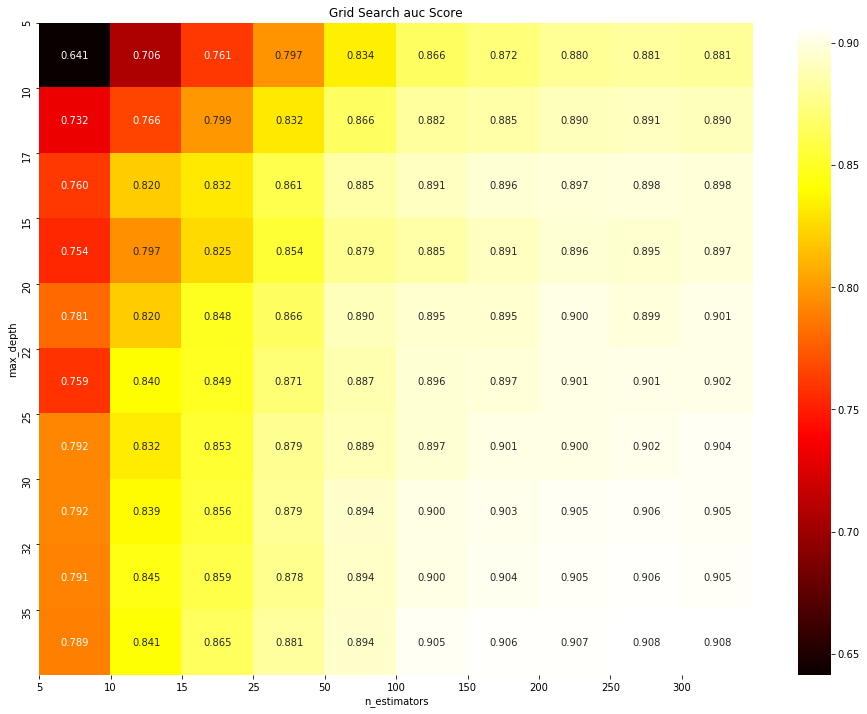

In [28]:


print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
#scores = model.mean_test_score.reshape(len(base_learners),len(depth))
#scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
score=model.grid_scores_ 
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i].mean_validation_score)

scores=np.array(scores).reshape(10,10)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()

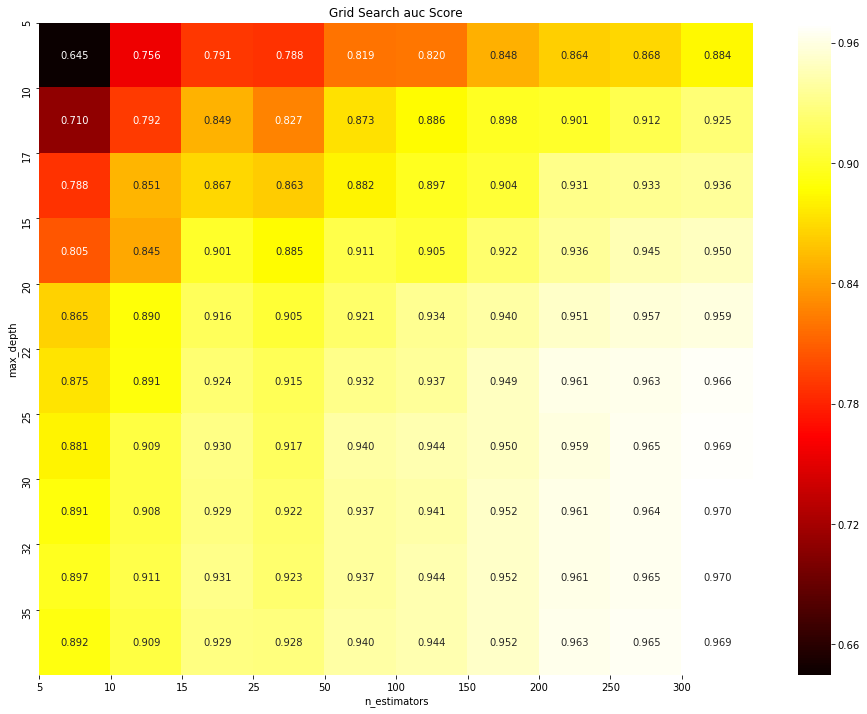

In [35]:
base_learners = [5,10,15,25,50,100,150,200,250,300]
depth = [5,10,17,15,20,22,25,30,32,35]
auc_scores=[]
for k in base_learners:
    for l in depth:
        dt = RandomForestClassifier(n_estimators=k,max_depth=l,n_jobs=-1 )
        dt.fit(train_70k, y_train)
        predict=dt.predict_proba(train_70k)[:,1]
        auc1=metrics.roc_auc_score(y_train, predict)
        auc_scores.append(auc1.mean())
        
score=auc_scores
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i])

scores=np.array(scores).reshape(10,10)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()        


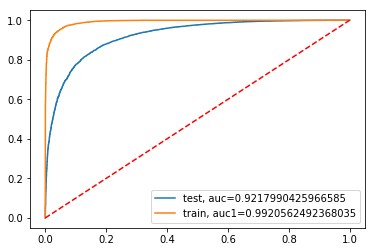

82.5221529373154


In [121]:
dt = RandomForestClassifier(n_estimators=300,max_depth=35)
dt.fit(train_70k, y_train)

predict=dt.predict_proba(test_30k)[:,1]
predict2=dt.predict(test_30k)
predict3=dt.predict(train_70k)
predict1=dt.predict_proba(train_70k)[:,1]
acc = accuracy_score(y_test, predict.round(), normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

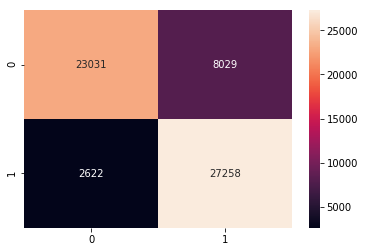

In [122]:
sample=confusion_matrix(y_test,predict2)
ax=sns.heatmap(sample,annot=True,fmt="d")  

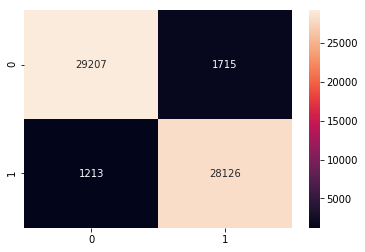

In [123]:
sample=confusion_matrix(y_train,predict3)
ax=sns.heatmap(sample,annot=True,fmt="d")  

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [26]:
dt = RandomForestClassifier(n_estimators=300,max_depth=35)
dt.fit(train_70k, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
importances=[]
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1][:20]

names=[]
names = count_vector.get_feature_names()
print(np.take(count_vector.get_feature_names(), indices[:20]))
names1=np.take(count_vector.get_feature_names(), indices[:20])
names1=str(names1)

['not' 'disappointed' 'great' 'worst' 'best' 'money' 'threw' 'waste'
 'return' 'horrible' 'awful' 'terrible' 'bad' 'love' 'would' 'refund'
 'disappointing' 'worse' 'thought' 'product']


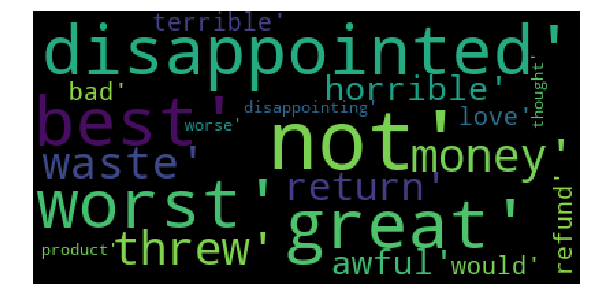

In [28]:
from wordcloud import WordCloud
#print(train_70k)
wordcloud = WordCloud(max_words=20).generate(names1)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [0]:
dt = RandomForestClassifier(n_jobs=-1)
param_grid = {'n_estimators': [5,10,15,25,50,100,150,200,250,300],'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
gsv = GridSearchCV(dt,param_grid,cv=3,scoring='roc_auc')
gsv.fit(tf_train70k,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

tf_train70k,y_train

In [27]:
base_learners = [5,10,15,25,50,100,150,200,250,300]

depth = [5,10,17,15,20,22,25,30,32,35]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
RFC = RandomForestClassifier(n_jobs = -1)
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3)
model.fit(tf_train70k,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tf_train70k,y_train))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.9816616902486812
The optimal number of base learners is :  300
The optimal number of depth is :  35


Best HyperParameter:  {'max_depth': 35, 'n_estimators': 300}
0.9163600249904669


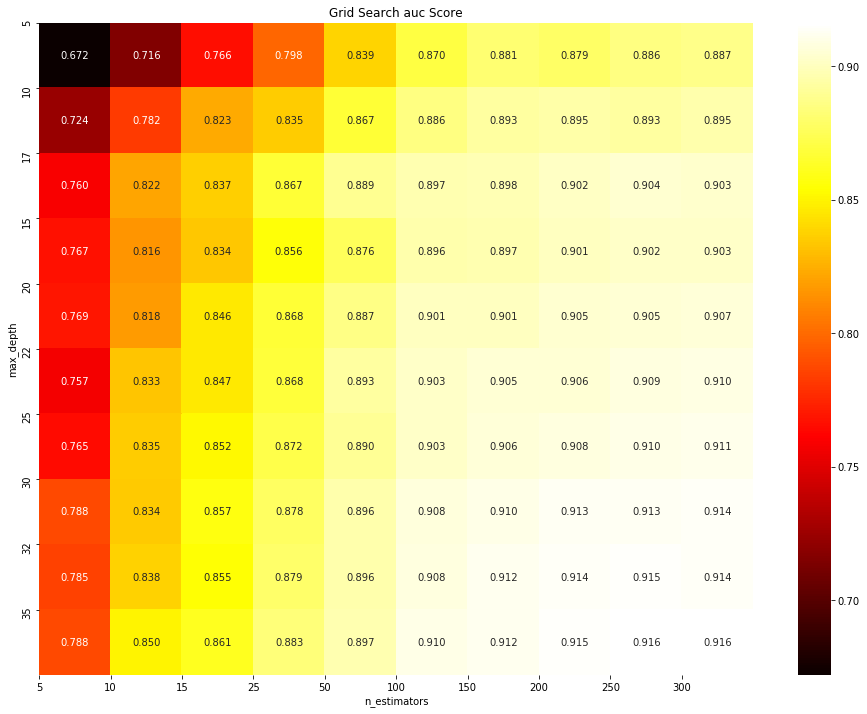

In [28]:


print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
#scores = model.mean_test_score.reshape(len(base_learners),len(depth))
#scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
score=model.grid_scores_ 
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i].mean_validation_score)

scores=np.array(scores).reshape(10,10)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()

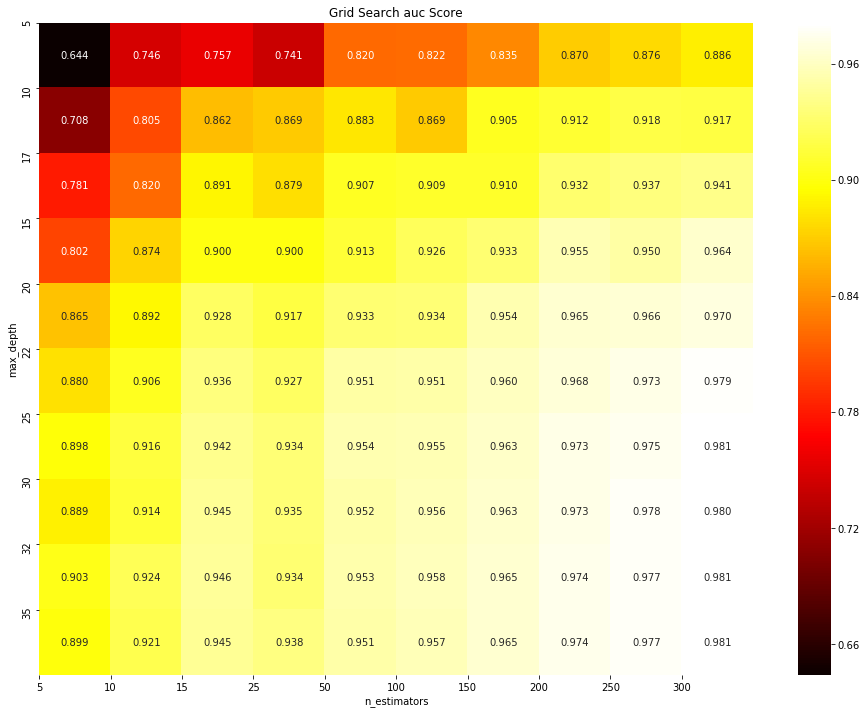

In [29]:
base_learners = [5,10,15,25,50,100,150,200,250,300]
depth = [5,10,17,15,20,22,25,30,32,35]
auc_scores=[]
for k in base_learners:
    for l in depth:
        dt = RandomForestClassifier(n_estimators=k,max_depth=l,n_jobs=-1 )
        dt.fit(tf_train70k, y_train)
        predict=dt.predict_proba(tf_train70k)[:,1]
        auc1=metrics.roc_auc_score(y_train, predict)
        auc_scores.append(auc1.mean())
        
score=auc_scores
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i])

scores=np.array(scores).reshape(10,10)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()        


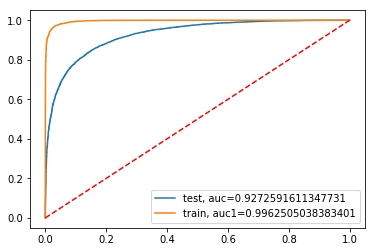

82.7797833935018


In [128]:
dt = RandomForestClassifier(n_estimators=300,max_depth=35,n_jobs=-1)
dt.fit(tf_train70k,y_train)

predict=dt.predict_proba(tf_test30k)[:,1]
predict2=dt.predict(tf_test30k)
predict3=dt.predict(tf_train70k)
predict1=dt.predict_proba(tf_train70k)[:,1]
acc = accuracy_score(y_test, predict.round(), normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

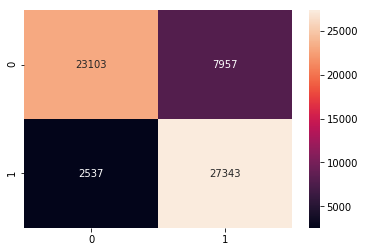

In [129]:
sample=confusion_matrix(y_test,predict2)
ax=sns.heatmap(sample,annot=True,fmt="d")  

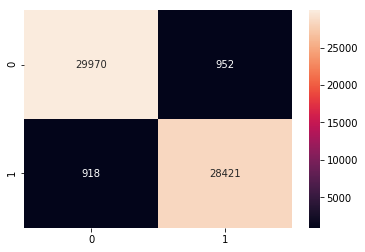

In [130]:
sample=confusion_matrix(y_train,predict3)
ax=sns.heatmap(sample,annot=True,fmt="d")  

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [30]:
dt = RandomForestClassifier(n_estimators=300,max_depth=35,n_jobs=-1)
dt.fit(tf_train70k,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
importances=[]
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1][:20]

names=[]
names = tfidf_vect.get_feature_names()
print(np.take(tfidf_vect.get_feature_names(), indices[:20]))
names1=np.take(tfidf_vect.get_feature_names(), indices[:20])
names1=str(names1)

['disappointed' 'not' 'great' 'waste' 'bad' 'horrible' 'money' 'terrible'
 'threw' 'awful' 'worst' 'would' 'best' 'love' 'return' 'away' 'received'
 'disappointing' 'thought' 'refund']


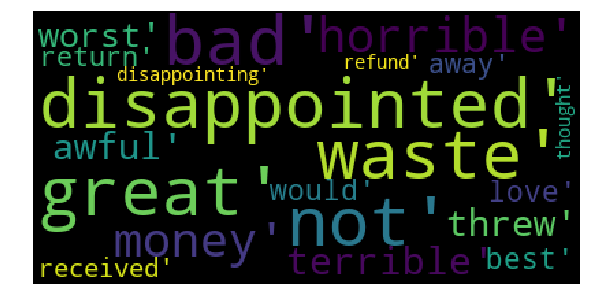

In [32]:
from wordcloud import WordCloud
#print(train_70k)
wordcloud = WordCloud(max_words=20).generate(names1)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [0]:
dt = RandomForestClassifier(n_jobs=-1)
param_grid = {'n_estimators': [10,25,50,100,150,200,250,300,350,400,450,500],'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
gsv = GridSearchCV(dt,param_grid,cv=3,scoring='roc_auc')
gsv.fit(sent_vectors,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

In [36]:
base_learners = [5,10,15,25,50,100,150,200,250,300]

depth = [5,10,17,15,20,22,25,30,32,35]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
RFC = RandomForestClassifier(n_jobs = -1)
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3)
model.fit(sent_vectors,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(sent_vectors,y_train))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.9997263511221857
The optimal number of base learners is :  300
The optimal number of depth is :  35


Best HyperParameter:  {'max_depth': 35, 'n_estimators': 300}
0.9018153503797602


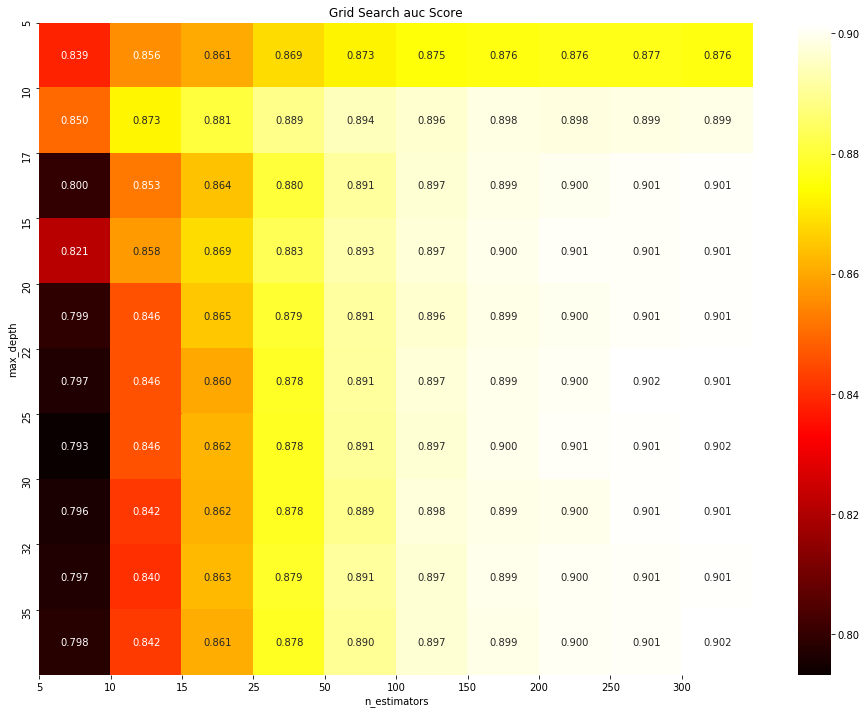

In [37]:


print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
#scores = model.mean_test_score.reshape(len(base_learners),len(depth))
#scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
score=model.grid_scores_ 
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i].mean_validation_score)

scores=np.array(scores).reshape(10,10)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()

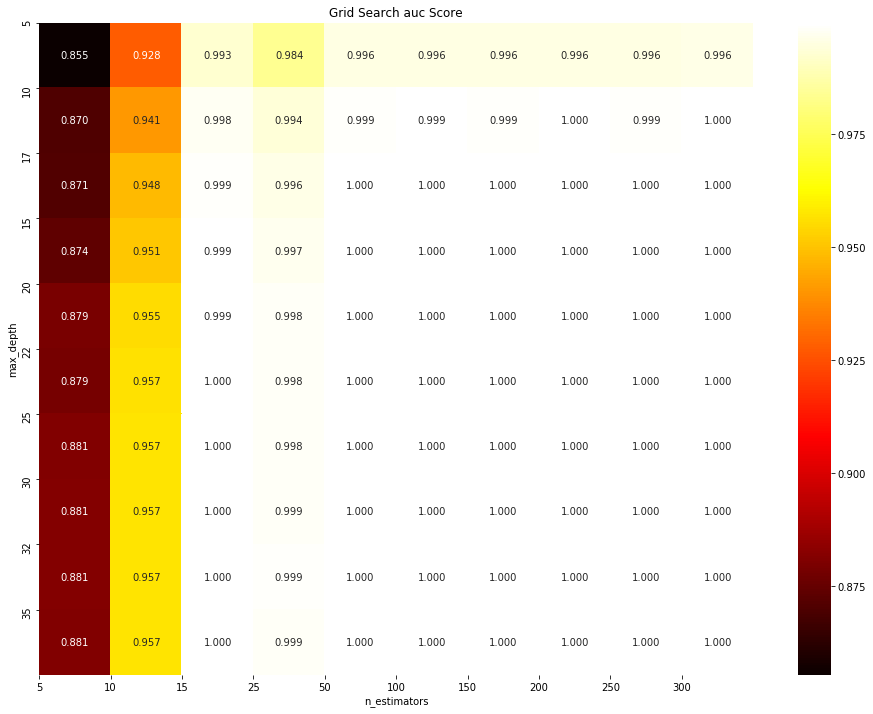

In [37]:
base_learners = [5,10,15,25,50,100,150,200,250,300]
depth = [5,10,17,15,20,22,25,30,32,35]
auc_scores=[]
for k in base_learners:
    for l in depth:
        dt = RandomForestClassifier(n_estimators=k,max_depth=l,n_jobs=-1 )
        dt.fit(sent_vectors, y_train)
        predict=dt.predict_proba(sent_vectors)[:,1]
        auc1=metrics.roc_auc_score(y_train, predict)
        auc_scores.append(auc1.mean())
        
score=auc_scores
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i])

scores=np.array(scores).reshape(10,10)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()        


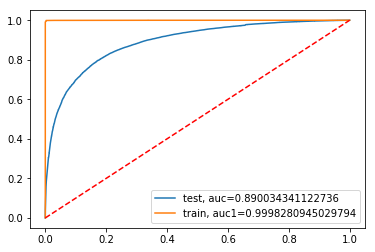

87.06120753672074


In [49]:
dt = RandomForestClassifier(n_estimators=300,max_depth=25,n_jobs=-1,class_weight='balanced')
dt.fit(sent_vectors,y_train)

predict=dt.predict_proba(sent_vectors_test)[:,1]
predict2=dt.predict(sent_vectors_test)
predict3=dt.predict(sent_vectors)
predict1=dt.predict_proba(sent_vectors)[:,1]
acc = accuracy_score(y_test, predict.round(), normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

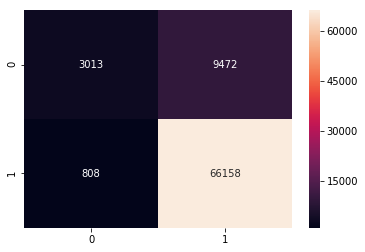

In [50]:
sample=confusion_matrix(y_test,predict2)
ax=sns.heatmap(sample,annot=True,fmt="d")  

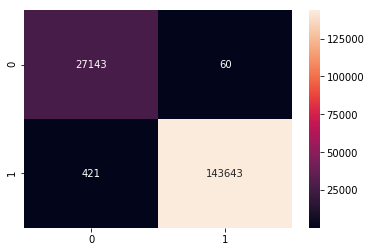

In [51]:
sample=confusion_matrix(y_train,predict3)
ax=sns.heatmap(sample,annot=True,fmt="d")   

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [34]:
base_learners = [5,10,15,25,50,100,150,200,250,300]

depth = [5,10,17,15,20,22,25,30,32,35]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
RFC = RandomForestClassifier(n_jobs = -1)
model = GridSearchCV(RFC, param_grid, scoring = 'roc_auc', cv=3)
model.fit(tfidf_sent_vectors,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tfidf_sent_vectors,y_train))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.9997376649541184
The optimal number of base learners is :  300
The optimal number of depth is :  30


Best HyperParameter:  {'max_depth': 30, 'n_estimators': 300}
0.8769781439241422


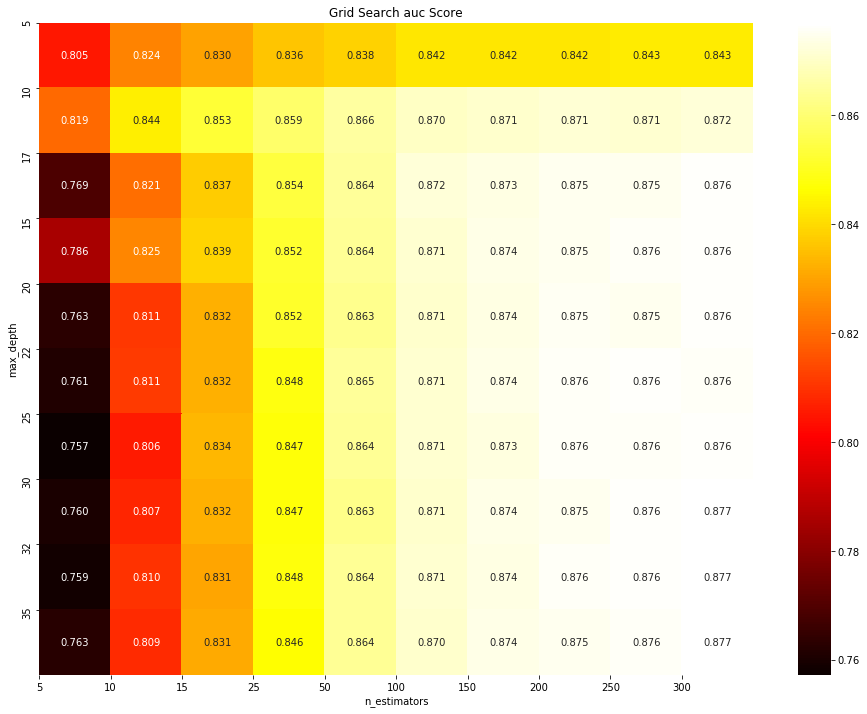

In [35]:



print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
#scores = model.mean_test_score.reshape(len(base_learners),len(depth))
#scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
score=model.grid_scores_ 
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i].mean_validation_score)

scores=np.array(scores).reshape(10,10)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()

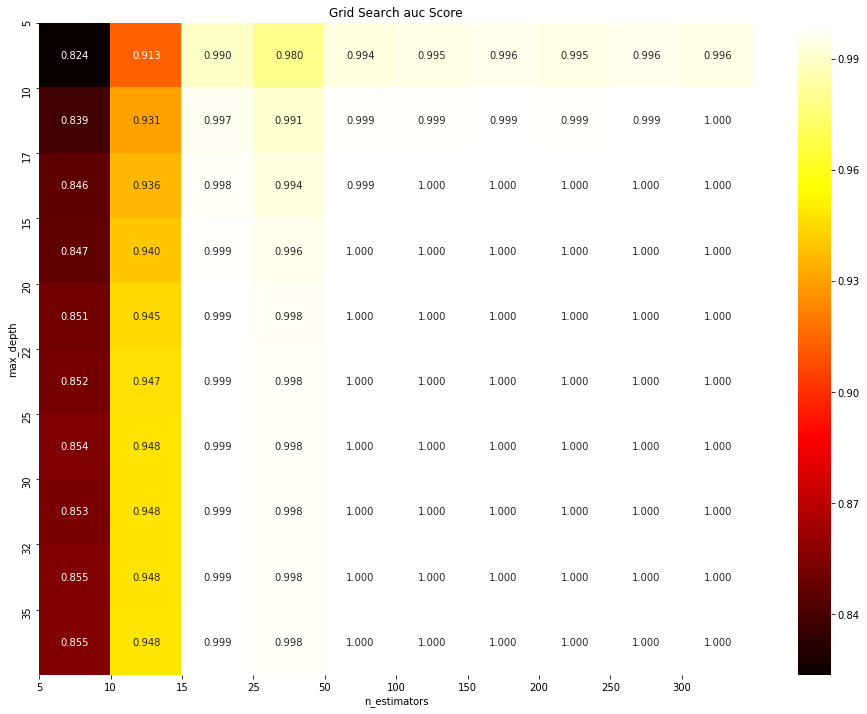

In [46]:
base_learners = [5,10,15,25,50,100,150,200,250,300]
depth = [5,10,17,15,20,22,25,30,32,35]
auc_scores=[]
for k in base_learners:
    for l in depth:
        dt = RandomForestClassifier(n_estimators=k,max_depth=l,n_jobs=-1 )
        dt.fit(tfidf_sent_vectors, y_train)
        predict=dt.predict_proba(tfidf_sent_vectors)[:,1]
        auc1=metrics.roc_auc_score(y_train, predict)
        auc_scores.append(auc1.mean())
        
score=auc_scores
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i])

scores=np.array(scores).reshape(10,10)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()        


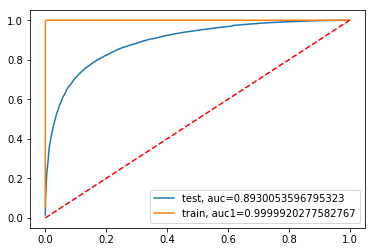

87.64143937772967


In [35]:
dt = RandomForestClassifier(n_estimators=300,max_depth=30,n_jobs=-1,class_weight='balanced')
dt.fit(tfidf_sent_vectors,y_train)

predict=dt.predict_proba(tfidf_sent_vectors_test)[:,1]
predict2=dt.predict(tfidf_sent_vectors_test)
predict3=dt.predict(tfidf_sent_vectors)
predict1=dt.predict_proba(tfidf_sent_vectors)[:,1]
acc = accuracy_score(y_test, predict.round(), normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

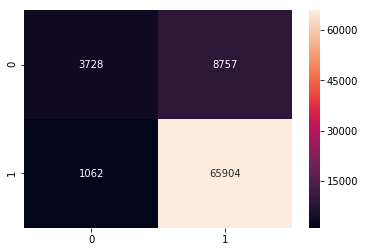

In [36]:
sample=confusion_matrix(y_test,predict2)
ax=sns.heatmap(sample,annot=True,fmt="d")  

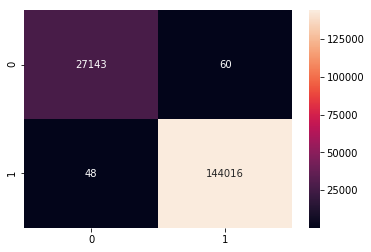

In [37]:
sample=confusion_matrix(y_train,predict3)
ax=sns.heatmap(sample,annot=True,fmt="d")  

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [40]:
from xgboost import XGBClassifier

base_learners = [25,50,75,90,100]

depth = [5,10,15,20,25]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
xgb = XGBClassifier(n_jobs=4 )
model = GridSearchCV(xgb, param_grid, scoring = 'roc_auc', cv=3)
model.fit(train_70k1,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(train_70k1,y_train))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy of the model :  0.995655442605639
The optimal number of base learners is :  100
The optimal number of depth is :  25


Best HyperParameter:  {'max_depth': 25, 'n_estimators': 100}
0.9281676051895845


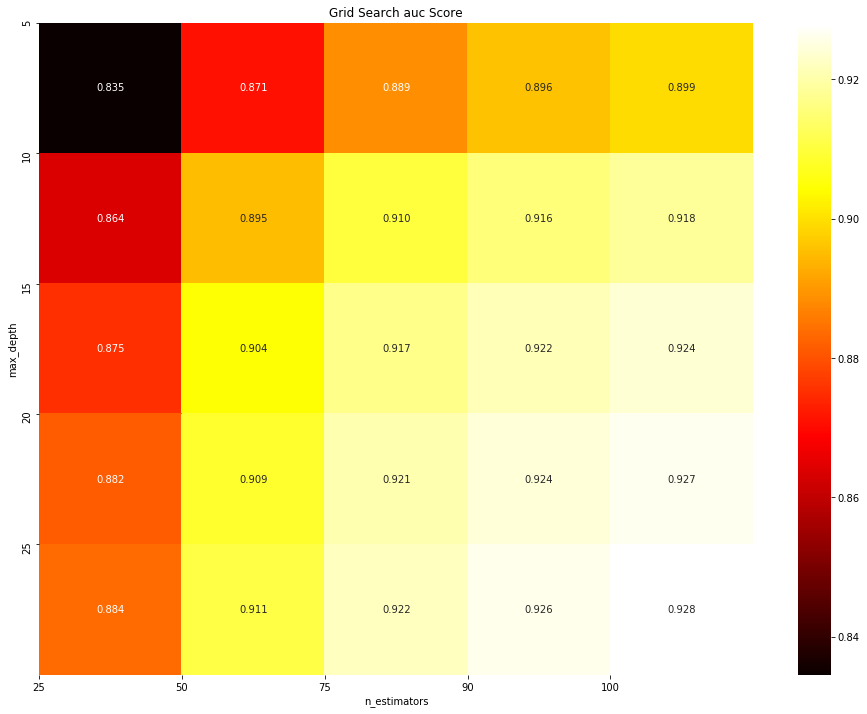

In [41]:



print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
#scores = model.mean_test_score.reshape(len(base_learners),len(depth))
#scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
score=model.grid_scores_ 
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i].mean_validation_score)

scores=np.array(scores).reshape(5,5)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()

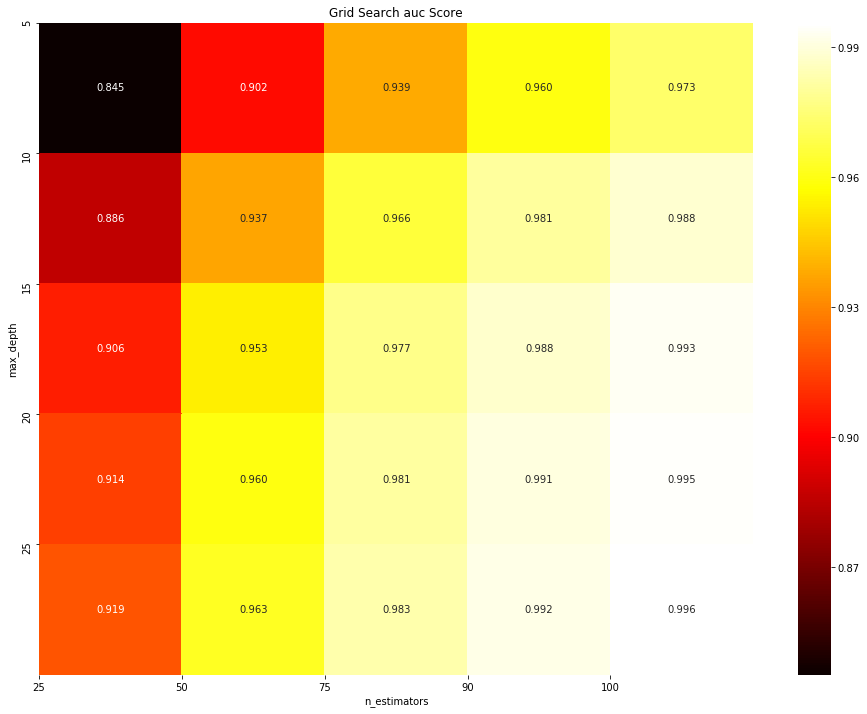

In [27]:
from xgboost import XGBClassifier

base_learners = [25,50,75,90,100]

depth = [5,10,15,20,25]
auc_scores=[]
for k in base_learners:
    for l in depth:
        xgb = XGBClassifier(n_estimators=k,max_depth=l,n_jobs=4)
        xgb.fit(train_70k1,y_train)
        predict=xgb.predict_proba(train_70k1)[:,1]
        auc1=metrics.roc_auc_score(y_train, predict)
        auc_scores.append(auc1.mean())
        
score=auc_scores
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i])

scores=np.array(scores).reshape(5,5)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()        


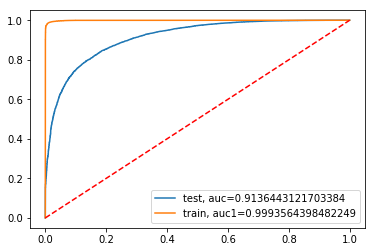

79.82605841811618


In [124]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=100,max_depth=25)
xgb.fit(train_70k1,y_train)
predict=xgb.predict_proba(test_30k1)[:,1]
predict2=xgb.predict(test_30k1)
predict3=xgb.predict(train_70k1)
predict1=xgb.predict_proba(train_70k1)[:,1]
acc = accuracy_score(y_test, predict.round(), normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

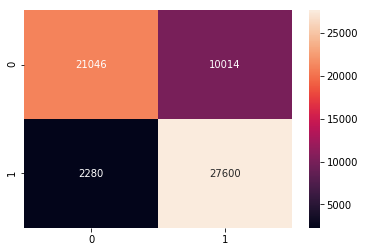

In [125]:
sample=confusion_matrix(y_test,predict2)
ax=sns.heatmap(sample,annot=True,fmt="d")  

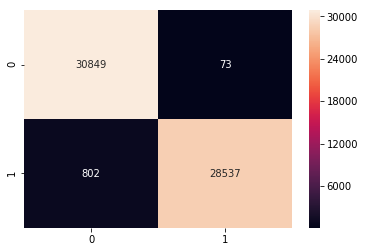

In [126]:
sample=confusion_matrix(y_train,predict3)
ax=sns.heatmap(sample,annot=True,fmt="d") 

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [47]:
from xgboost import XGBClassifier

base_learners = [25,50,75,90,100]

depth = [5,10,15,20,25]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
xgb = XGBClassifier(n_jobs=4 )
model = GridSearchCV(xgb, param_grid, scoring = 'roc_auc', cv=3)
model.fit(tf_train70k1,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tf_train70k1,y_train))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy of the model :  0.997727654730266
The optimal number of base learners is :  100
The optimal number of depth is :  25


Best HyperParameter:  {'max_depth': 25, 'n_estimators': 100}
0.9262262282894137


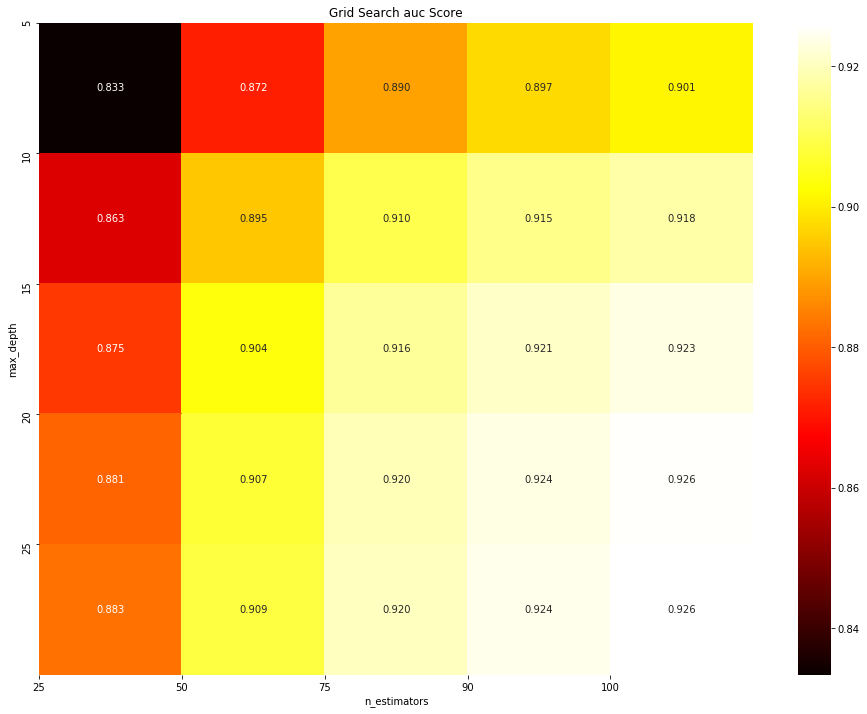

In [48]:



print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
#scores = model.mean_test_score.reshape(len(base_learners),len(depth))
#scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
score=model.grid_scores_ 
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i].mean_validation_score)

scores=np.array(scores).reshape(5,5)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()

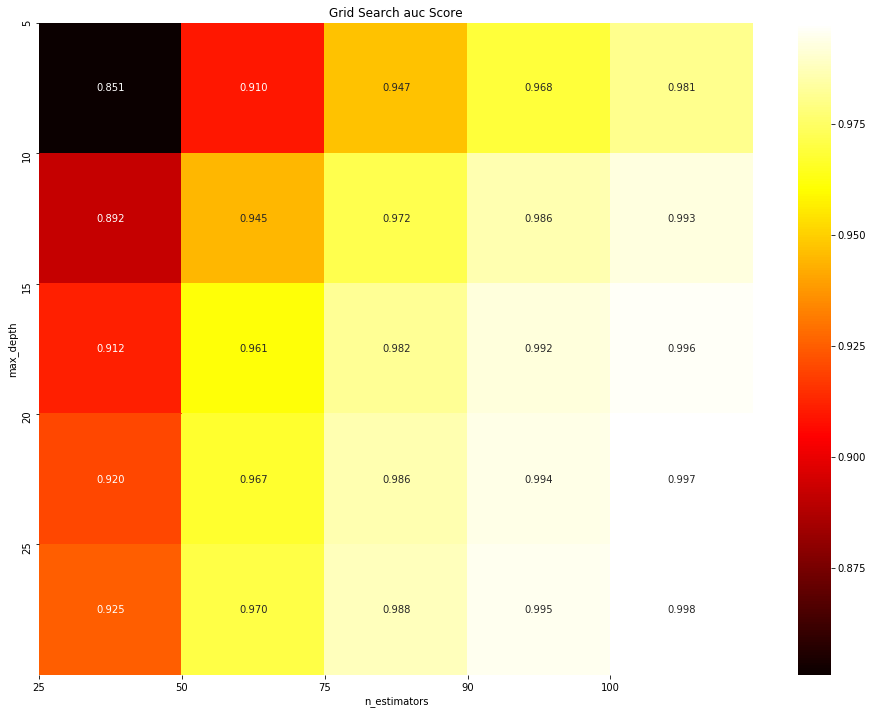

In [30]:
from xgboost import XGBClassifier

base_learners = [25,50,75,90,100]

depth = [5,10,15,20,25]
auc_scores=[]
for k in base_learners:
    for l in depth:
        xgb = XGBClassifier(n_estimators=k,max_depth=l,n_jobs=4)
        xgb.fit(tf_train70k1,y_train)
        predict=xgb.predict_proba(tf_train70k1)[:,1]
        auc1=metrics.roc_auc_score(y_train, predict)
        auc_scores.append(auc1.mean())
        
score=auc_scores
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i])

scores=np.array(scores).reshape(5,5)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()        


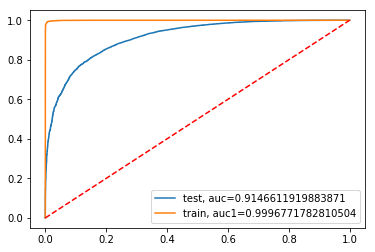

79.67509025270758


In [131]:
xgb = XGBClassifier(n_estimators=100,max_depth=25)
xgb.fit(tf_train70k1,y_train)
predict=xgb.predict_proba(tf_test30k1)[:,1]
predict2=xgb.predict(tf_test30k1)
predict3=xgb.predict(tf_train70k1)
predict1=xgb.predict_proba(tf_train70k1)[:,1]
acc = accuracy_score(y_test, predict.round(), normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

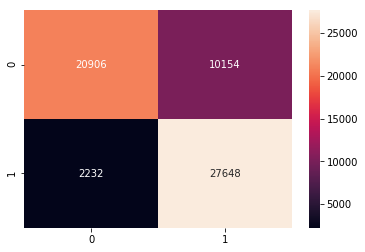

In [132]:
sample=confusion_matrix(y_test,predict2)
ax=sns.heatmap(sample,annot=True,fmt="d")  

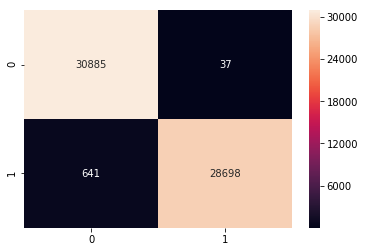

In [133]:
sample=confusion_matrix(y_train,predict3)
ax=sns.heatmap(sample,annot=True,fmt="d")  

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [57]:
from xgboost import XGBClassifier

base_learners = [25,50,75,90,100]

depth = [5,10,15,20,25]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
xgb = XGBClassifier(n_jobs=4 )
model = GridSearchCV(xgb, param_grid, scoring = 'roc_auc', cv=3)
model.fit(sent_vectors1,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(sent_vectors1,y_train))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy of the model :  0.9999897538908102
The optimal number of base learners is :  100
The optimal number of depth is :  15


Best HyperParameter:  {'max_depth': 15, 'n_estimators': 100}
0.9137949964867337


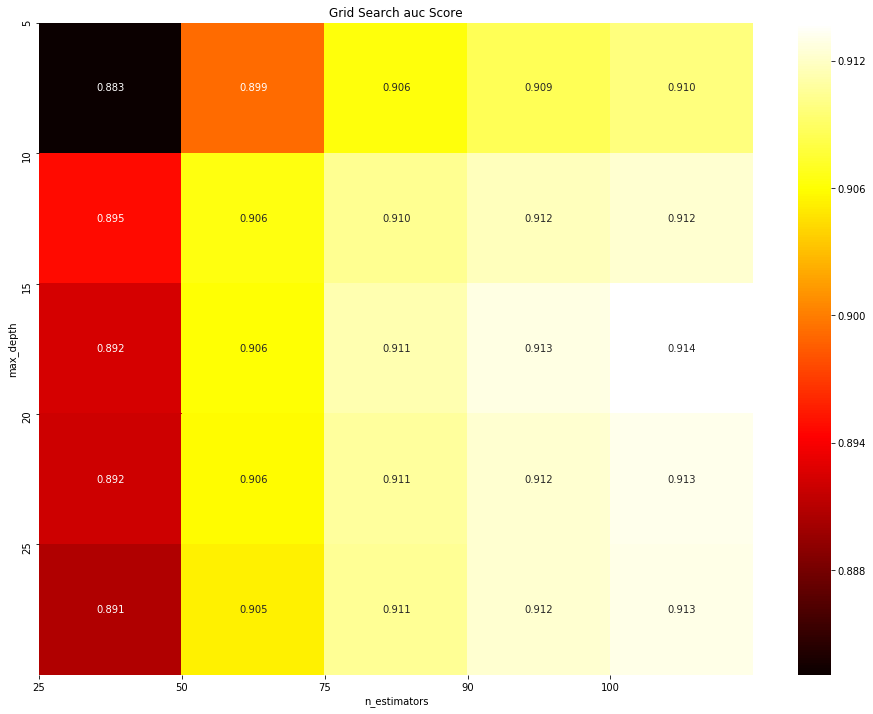

In [58]:



print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
#scores = model.mean_test_score.reshape(len(base_learners),len(depth))
#scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
score=model.grid_scores_ 
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i].mean_validation_score)

scores=np.array(scores).reshape(5,5)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()

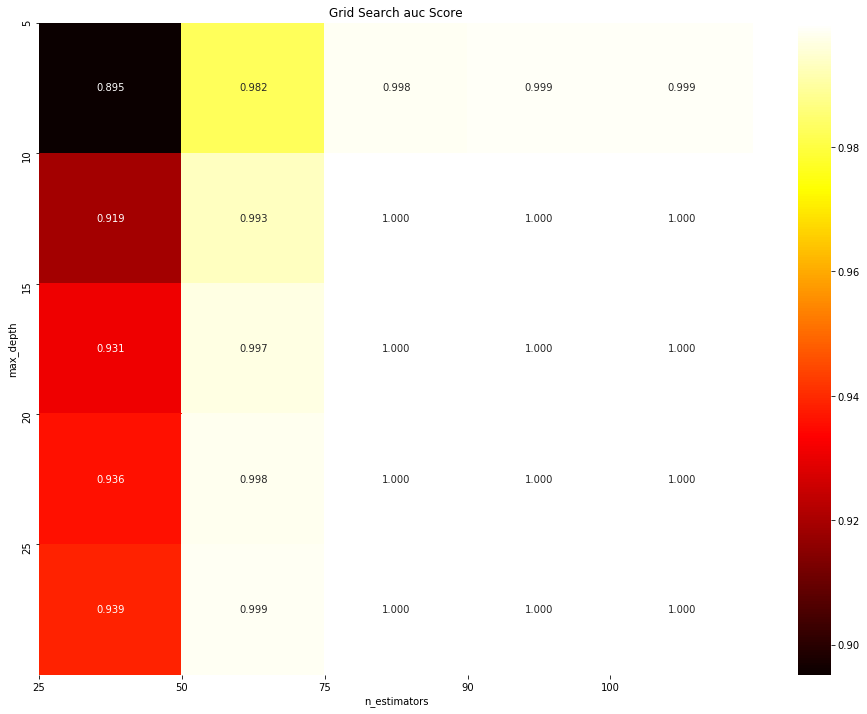

In [38]:
from xgboost import XGBClassifier

base_learners = [25,50,75,90,100]

depth = [5,10,15,20,25]
auc_scores=[]
for k in base_learners:
    for l in depth:
        xgb = XGBClassifier(n_estimators=k,max_depth=l,n_jobs=4)
        xgb.fit(sent_vectors1,y_train)
        predict=xgb.predict_proba(sent_vectors1)[:,1]
        auc1=metrics.roc_auc_score(y_train, predict)
        auc_scores.append(auc1.mean())
        
score=auc_scores
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i])

scores=np.array(scores).reshape(5,5)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()        


In [53]:
from xgboost import XGBClassifier


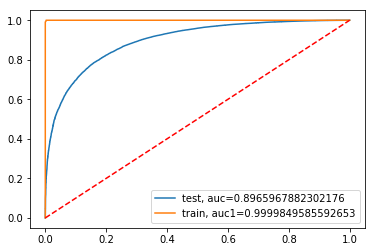

88.76917848736957


In [54]:
xgb = XGBClassifier(n_estimators=100,max_depth=15)
xgb.fit(sent_vectors1,y_train)

predict=xgb.predict_proba(sent_vectors_test1)[:,1]
predict2=xgb.predict(sent_vectors_test1)
predict3=xgb.predict(sent_vectors1)
predict1=xgb.predict_proba(sent_vectors1)[:,1]
acc = accuracy_score(y_test, predict.round(), normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

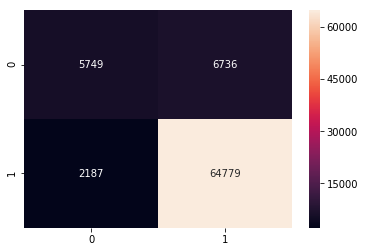

In [55]:
sample=confusion_matrix(y_test,predict2)
ax=sns.heatmap(sample,annot=True,fmt="d")  

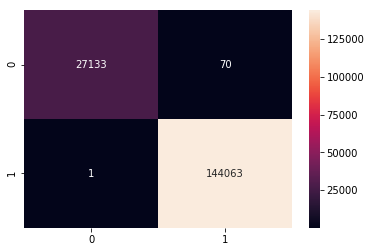

In [56]:
sample=confusion_matrix(y_train,predict3)
ax=sns.heatmap(sample,annot=True,fmt="d")  

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [65]:
from xgboost import XGBClassifier

base_learners = [25,50,75,90,100]

depth = [5,10,15,20,25]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
xgb = XGBClassifier(n_jobs=4 )
model = GridSearchCV(xgb, param_grid, scoring = 'roc_auc', cv=3)
#print(tfidf_sent_vectors.shape)
model.fit(tfidf_sent_vectors1,y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tfidf_sent_vectors1,y_train))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy of the model :  0.9999949917759643
The optimal number of base learners is :  100
The optimal number of depth is :  25


Best HyperParameter:  {'max_depth': 25, 'n_estimators': 100}
0.8924079819004891


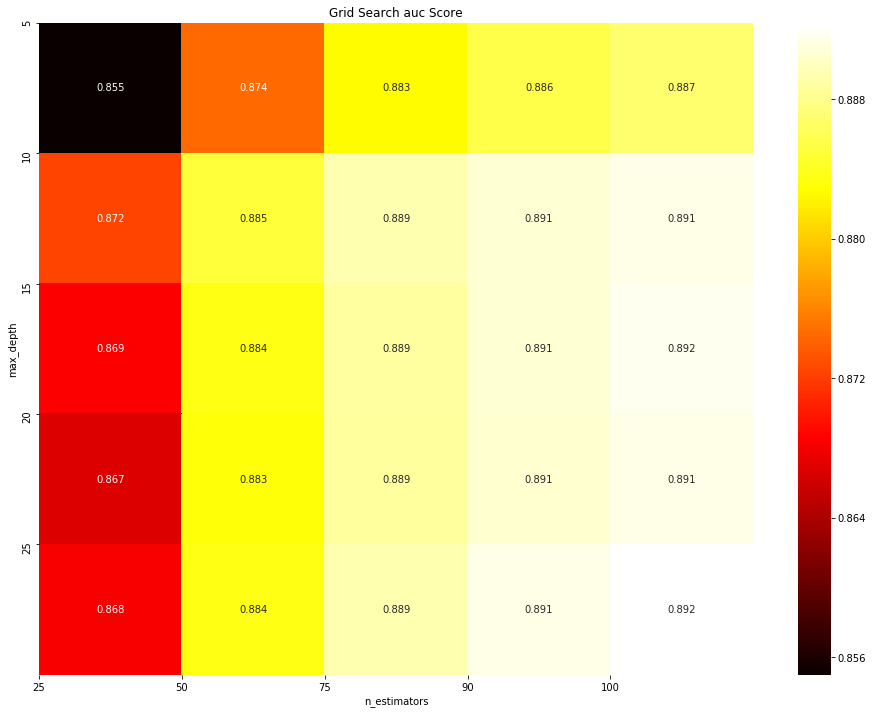

In [66]:



print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
#scores = model.mean_test_score.reshape(len(base_learners),len(depth))
#scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))
score=model.grid_scores_ 
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i].mean_validation_score)

scores=np.array(scores).reshape(5,5)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()

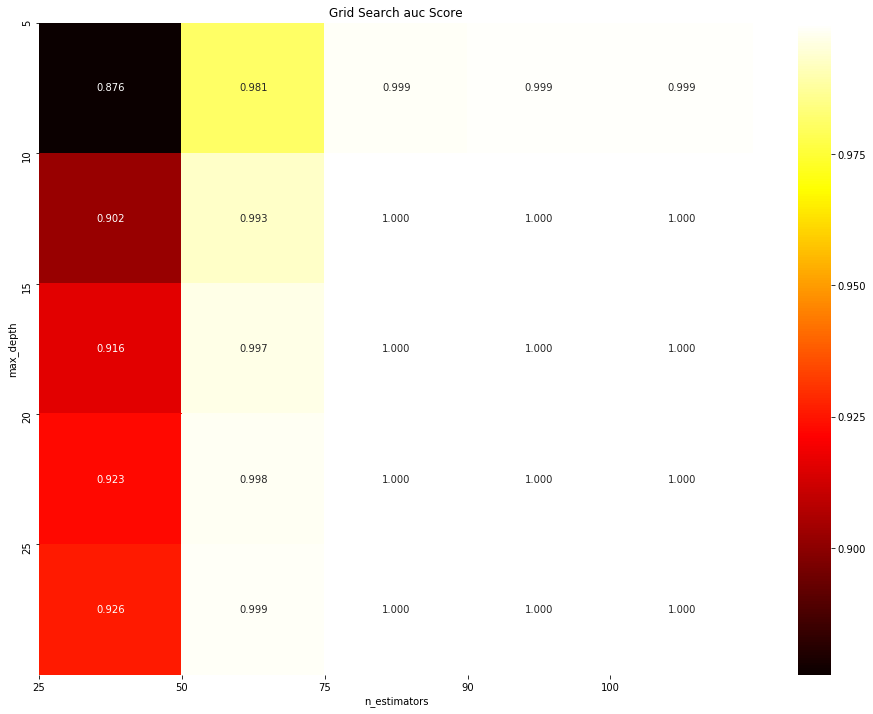

In [47]:
from xgboost import XGBClassifier

base_learners = [25,50,75,90,100]

depth = [5,10,15,20,25]
auc_scores=[]
for k in base_learners:
    for l in depth:
        xgb = XGBClassifier(n_estimators=k,max_depth=l,n_jobs=4)
        xgb.fit(tfidf_sent_vectors1,y_train)
        predict=xgb.predict_proba(tfidf_sent_vectors1)[:,1]
        auc1=metrics.roc_auc_score(y_train, predict)
        auc_scores.append(auc1.mean())
        
score=auc_scores
scores=[]
for i in range((len(base_learners)*len(depth))):
    scores.append(score[i])

scores=np.array(scores).reshape(5,5)  

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search auc Score')
plt.show()        


In [42]:
from xgboost import XGBClassifier

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


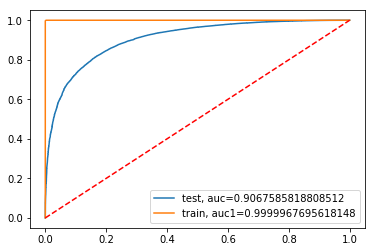

88.98566412002367


In [43]:
xgb = XGBClassifier(n_estimators=100,max_depth=25)
xgb.fit(tfidf_sent_vectors1,y_train)

predict=xgb.predict_proba(tfidf_sent_vectors_test1)[:,1]
predict2=xgb.predict(tfidf_sent_vectors_test1)
predict3=xgb.predict(tfidf_sent_vectors1)
predict1=xgb.predict_proba(tfidf_sent_vectors1)[:,1]
acc = accuracy_score(y_test, predict.round(), normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

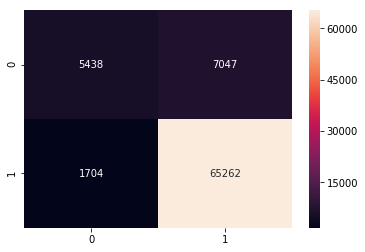

In [44]:
sample=confusion_matrix(y_test,predict2)
ax=sns.heatmap(sample,annot=True,fmt="d")  

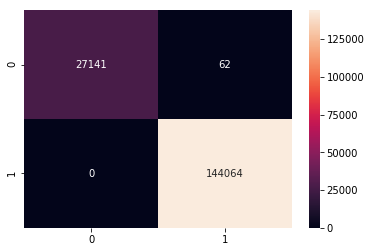

In [45]:
sample=confusion_matrix(y_train,predict3)
ax=sns.heatmap(sample,annot=True,fmt="d")  

# [6] Conclusions

<table>
    <tr>
        <th>model</th>
        <th>test accuracy</th>
        <th>depth</th>
        <th>splits</th>
        <th>test auc</th>
        <th>train auc</th>
        
    </tr>
    <tr>
        <td>BOW</td>
        <td>85.42</td>
        <td>35</td>
        
        
        <td>300</td>
        <td>0.90</td>
        <td>0.97</td>
            
    </tr>
    <tr>
        <td>TFIDF</td>
        <td>85.41</td>
        <td>35</td>
        
        
        <td>300</td>
        <td>0.91</td>
        <td>0.98</td>
    </tr>
    <tr>
        <td>avg w2v</td>
        <td>87</td>
        <td>35</td>
        
        
        <td>300</td>
        <td>0.89</td>
        <td>0.99</td>
     </tr>
     <tr>
         <td>tfidf-avg w2v</td>
         <td>89</td>
         <td>30</td>
         
         
         <td>300</td>
         <td>0.87</td>
         <td>0.85</td>
     </tr>    
    
</table>    



from the above table and by looking at the confusion matrix for every model we can conclude that BOW,TFIDF and avg w2v models are doing well in classifying the points with out any bias.

# XGBOOST Observation:

<table>
    <tr>
        <th>model</th>
        <th>test accuracy</th>
        <th>depth</th>
        <th>splits</th>
        <th>test auc</th>
        <th>train auc</th>
        
    </tr>
    <tr>
        <td>BOW</td>
        <td>90.75</td>
        <td>25</td>
        
        
        <td>100</td>
        <td>0.92</td>
        <td>0.99</td>
            
    </tr>
    <tr>
        <td>TFIDF</td>
        <td>90.85</td>
        <td>25</td>
        
        
        <td>100</td>
        <td>0.92</td>
        <td>0.99</td>
    </tr>
    <tr>
        <td>avg w2v</td>
        <td>88</td>
        <td>15</td>
        
        
        <td>100</td>
        <td>0.89</td>
        <td>0.99</td>
     </tr>
     <tr>
         <td>tfidf-avg w2v</td>
         <td>88.98</td>
         <td>25</td>
         
         
         <td>100</td>
         <td>0.90</td>
         <td>0.99</td>
     </tr>    
    
</table>    

